# **VAE-GAN to Generate Neonatal Brain Images and Estimate Brain Age**

This coursework is from my Advance Machine Learning modules, led by Dr Jorge Cardoso and Dr Emma Robinson. The aim of this coursework is to implement and validate a Variational Autoencoder Generative Adversarial Network (VAE-GAN) - taking inspiration from the original paper by ABL Larsen et al. https://arxiv.org/abs/1512.09300. We will add a regression layer in the latent space to further validate the network through prediction of brain age from the slices.

<img src="https://miro.medium.com/max/2992/0*KEmfTtghsCDu6UTb.png" width="400">


The data used in this coursework is a 2D dataset of ~800 axial slices through ***neonatal*** brain MRI. The Gestational Age at scan (GA) of the individuals ranges from ~30 to 40 weeks. Each slice therefore has an associated ground-truth label indicating the GA of each slice at scan time.

**The networks will be created from scratch (layer by layer).**



# **Part 1 - Load and Create Dataset and Dataloader**

## Data Notes

The data used in this coursework is composed from ~800 axial neonatal brain slices taken from the open-source Developing Human Connectome Project ([dHCP](https://www.developingconnectome.org/)) paired with Gestational Age (GA) labels in the range 29-40 weeks.

In [2]:
# Reset the notebook when a lot of memories were leaked
# %reset
import torch
print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")

Allocated GPU memory: 0.00 MB


In [3]:
# Import library and set up environment
# General library
import os as os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)
# Specific library needed for the project
import nibabel as nib

cuda
Number of GPU workers available: 2


In [4]:
# For Kaggle
# Exploring Kaggle environment
def list_folder_tree(path, indent=''):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(indent + '📁 ' + item)  # Print folder name
            list_folder_tree(item_path, indent + '  ')  # Recursively explore subfolders
#         else:
#             print(indent + '📄 ' + item)  # Print file name

def list_current_folder_tree(path, indent=''):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(indent + '📁 ' + item)  # Print folder name
        else:
            print(indent + '📄 ' + item)  # Print file name

# Specify the root folder path
root_path = '/kaggle/input/vae-gan-coursework-hung/sub-dhcp-2d/'
# Call the function to list the folder tree
list_current_folder_tree(root_path)

📁 validation
📁 test
📁 train
📄 labels.pkl


             Subject    Age
0    train-subject-1  43.29
1    train-subject-2  38.71
2    train-subject-3  40.43
3    train-subject-4  42.14
4    train-subject-5  40.43
..               ...    ...
834   test-subject-5  39.29
835   test-subject-6  40.29
836   test-subject-7  41.14
837   test-subject-8  41.86
838   test-subject-9  32.43

[839 rows x 2 columns]
Image size torch.Size([196, 230])
Image mean 0.1755240729758345
Image std 0.05063286447974206
Image min 0.0
Image max 0.6555793536589466


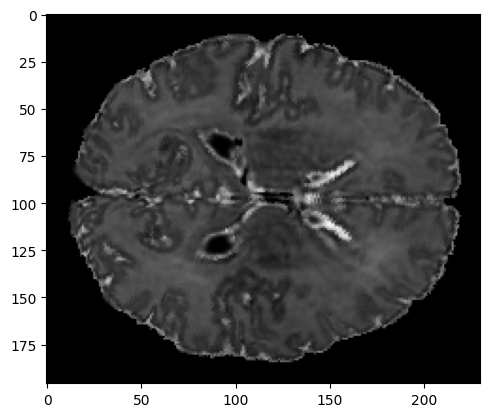

In [5]:
# LOAD THE DATASET AND LABELS: BRAIN SLICES ARE IN 'sub-dhcp-2d.zip' AND AGE LABELS ARE IN 'labels.pkl'
import pickle
meta_data_path = os.path.join(root_path, 'labels.pkl')
data_path = root_path
train_data_path = os.path.join(data_path, "train")
val_data_path = os.path.join(data_path, "validation")
test_data_path = os.path.join(data_path, "test")
with open(meta_data_path, 'rb') as file:
    metadata_labels = pickle.load(file)
    print(metadata_labels)
# Open 1 image to view
# # Collab
# def open_and_get_image_data(path, file_name):
#     file_name = f"{file_name}.nii.gz"
#     image = nib.load(os.path.join(path, file_name))
#     nii_data = image.get_fdata()
#     tensor = torch.from_numpy(nii_data)
#     return tensor
# Kaggle
def open_and_get_image_data(path, file_name):
    file_name = f"{file_name}.nii"
    for file in os.listdir(os.path.join(path, file_name)):
        if file.endswith(".nii"):
            image = nib.load(os.path.join(path, file_name,file))
            break
    nii_data = image.get_fdata()
    tensor = torch.from_numpy(nii_data)
    return tensor

# Open 1 image to view
file_name = "train-subject-1"
tensor = open_and_get_image_data(train_data_path, file_name)
plt.imshow(tensor, cmap = "gray")
print(f"Image size {tensor.size()}")
# Get 100 image and get their mean, std of pixel
image_stack = []
for i in range(1, 101):
    image_stack.append(open_and_get_image_data(train_data_path, f"train-subject-{i}"))
image_stack = torch.stack(image_stack, dim = 0)
non_zero_image_stack = image_stack[image_stack>0]
image_mean=non_zero_image_stack.mean().item()
image_std=non_zero_image_stack.std().item()
print(f"Image mean {image_mean}")
print(f"Image std {image_std}")
print(f"Image min {image_stack.min()}")
print(f"Image max {image_stack.max()}")


zero_pixel_after_transform -3.4666036531680082
Mean age: 39.94752085816448
Std age: 3.4356930801315917
Test: 755
Test: torch.Size([1, 196, 230])
Test: tensor([1.3047])
Dataset: train size 755, validation size 75, test size 9
Loader: train size 47, validation size 5, test size 1


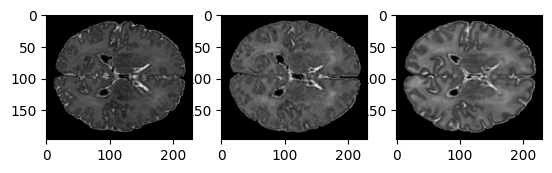

In [6]:
# CREATE DATASET AND DATALOADERS WITH DATA AUGMENTATION TRANSFORMS
# DATASET
from torchvision.transforms import Compose, Normalize, RandomVerticalFlip, RandomRotation

# Define the data augmentation transform
augmentation_transform = Compose([
    RandomVerticalFlip(p=0.5),
])

# Define the full transform
image_transform = Compose([
    Normalize(mean=image_mean, std=image_std),
])
zero_pixel_after_transform = -image_mean/image_std
print(f"zero_pixel_after_transform {zero_pixel_after_transform}")

# Get mean, std of age
age = metadata_labels.values[:,1].astype(float)
mean_age = age.mean()
std_age = age.std()
print(f"Mean age: {mean_age}")
print(f"Std age: {std_age}")
# Function to normalize age
def normalize_age(x):
    return (x-mean_age)/std_age
def denormalize_age(x):
    return (x*std_age)+mean_age

class brain_image_dataset(Dataset):
    def __init__(self, data_path, meta_data_path,
                 file_name_start_string, image_transform=None,
                 augmentation_transform=None):
        # Store meta data and path
        with open(meta_data_path, 'rb') as file:
            self.metadata_labels = pickle.load(file).values
        self.metadata_labels = {data[0]: data[1] for data in self.metadata_labels if data[0].startswith(file_name_start_string)}
        self.data_path = data_path
        self.file_name_start_string = file_name_start_string
        assert len(os.listdir(self.data_path)) == len(self.metadata_labels), "Length of metadata and folder do not match"
        # Check the file name and meta data match
        folder_file = os.listdir(self.data_path)
        for name in self.metadata_labels.keys():
            assert name+".nii" in folder_file, "Name of metadata and folder do not match" # Kaggle
#             assert name+".nii.gz" in folder_file, "Name of metadata and folder do not match" # Colab
        self.image_transform = image_transform
        self.augmentation_transform = augmentation_transform
    def __len__(self):
        # Return length of datasetss
        return len(self.metadata_labels)
    def __getitem__(self, index):
        # Concatenate data file names
        file_name = f"{self.file_name_start_string}{index+1}"
        file_path = os.path.join(self.data_path, f"{file_name}.nii.gz")
        # Go into the folder with file name and read data
        image = open_and_get_image_data(self.data_path, file_name)
        # Transformation of data
        image = image.unsqueeze(0).to(torch.float)
        if self.image_transform:
            image = self.image_transform(image)
        if self.augmentation_transform:
            image = self.augmentation_transform(image)
        # Get the age of image
        label = torch.tensor([float(self.metadata_labels[file_name])])
        label = normalize_age(label)
        return image, label

# Test
file_name_start_string = "train-subject-"
test = brain_image_dataset(train_data_path, meta_data_path, file_name_start_string)
print(f"Test: {len(test)}")
print(f"Test: {test[754][0].size()}")
print(f"Test: {test[754][1]}")

# Create dataset
train_dataset = brain_image_dataset(train_data_path, meta_data_path, "train-subject-",
                                    image_transform=image_transform, augmentation_transform=augmentation_transform)
val_dataset = brain_image_dataset(val_data_path, meta_data_path, "validation-subject-",
                                 image_transform=image_transform)
test_dataset = brain_image_dataset(test_data_path, meta_data_path, "test-subject-",
                                  image_transform=image_transform)
# Test
print(f"Dataset: train size {len(train_dataset)}, validation size {len(val_dataset)}, test size {len(test_dataset)}")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(train_dataset[0][0].squeeze(), cmap = "gray")
ax2.imshow(val_dataset[0][0].squeeze(), cmap = "gray")
ax3.imshow(test_dataset[0][0].squeeze(), cmap = "gray")

# Create dataloader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(f"Loader: train size {len(train_loader)}, validation size {len(val_loader)}, test size {len(test_loader)}")


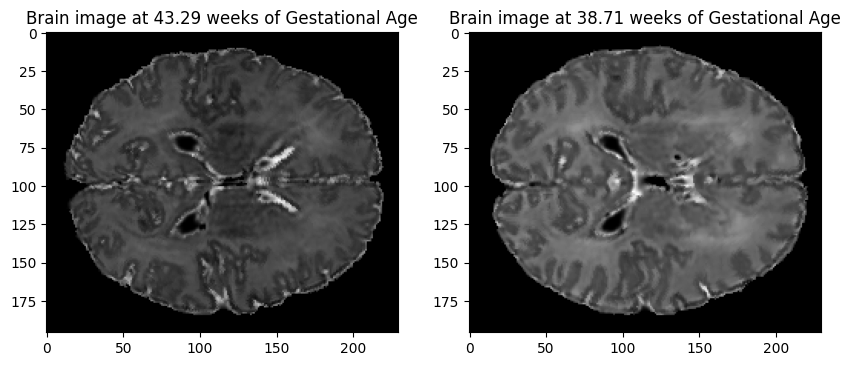

In [7]:
# DISPLAY AN EXAMPLE OF 2 SUBJECTS (BRAIN SLICE WITH AGE LABEL ASSOCIATED TO SUBJECT)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.imshow(train_dataset[0][0].squeeze(), cmap = "gray")
ax1.set_title(f"Brain image at {round(denormalize_age(train_dataset[0][1]).item(),2)} weeks of Gestational Age")
ax2.imshow(train_dataset[1][0].squeeze(), cmap = "gray")
ax2.set_title(f"Brain image at {round(denormalize_age(train_dataset[1][1]).item(),2)} weeks of Gestational Age")
plt.show()

## Comment
### Because the images are mirrored over vertical axis, random vertical flip help doubling the number of training set.

# **Part 2 - Regression Network: Predict Brain Age using an Encoder Model**

I will create a convolutional neural network model to perform a supervised regression task. I will use an encoder architecture to predict the brain age of the brain images. 

## **Note** The target proposed are: $1 > MAE \ge 0.5 $

## Some basic architecture for the networks

In [8]:
# Define Swish as an activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define a resdidual block
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, mode="level", activation_func=nn.LeakyReLU):
    '''
      in_channels - integer - the number of feature channels the first
                              convolution will receive
      out_channels - integer - the number of feature channels the last
                               convolution will output

      mode - string - defines what the block will do
           - "upsample" means the block wil double the spatial size
           - "downsample" means the block will halve the spatial size
           - "level" means the block will not change the spatial dimension
    '''
    super().__init__()
    assert kernel_size%2 == 1, "please use odd kernel_size"
    assert type(activation_func) == type, "activation_func should be a class"
    assert type(activation_func) == type, f"activation_func {activation_func} should be a class"
    padding = (kernel_size-1)//2 # Padding for each kernel
    if mode == "upsample":
      self.main_forward = nn.Sequential(
          nn.ConvTranspose2d(
              in_channels=in_channels,
              out_channels=out_channels,
              kernel_size=4,
              stride=2,
              padding=1,
          ),
          nn.BatchNorm2d(out_channels),
          activation_func(),
          nn.Dropout(),
          nn.Conv2d(
              in_channels=out_channels,
              out_channels=out_channels,
              kernel_size=kernel_size,
              stride=1,
              padding=padding,
          ),
      )
      self.residual_forward = nn.ConvTranspose2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=4,
          stride=2,
          padding=1,
      )
    else:
      self.main_forward = nn.Sequential(
          nn.Conv2d(
              in_channels=in_channels,
              out_channels=out_channels,
              kernel_size=kernel_size,
              stride=2 if mode == "downsample" else 1,
              padding=padding,
          ),
          nn.BatchNorm2d(out_channels),
          activation_func(),
          nn.Dropout(),
          nn.Conv2d(
              in_channels=out_channels,
              out_channels=out_channels,
              kernel_size=kernel_size,
              stride=1,
              padding=padding,
          ),
      )
      self.residual_forward = nn.Conv2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=kernel_size,
          stride=2 if mode == "downsample" else 1,
          padding=padding,
      )
#
  def forward(self, x):
    out = self.main_forward(x)
    x = out + self.residual_forward(x)
    return x


# Test
test = ResBlock(1, 3, 7, "level", nn.LeakyReLU)
test = ResBlock(1, 3, 7, "upsample", Swish)
x = torch.rand((100, 1, 31, 31))
print(x.size())
print(test(x).size())

# Define a multilayer perceptron
class MLP(nn.Module):
    def __init__(self, number_of_features, activation_func=nn.LeakyReLU):
        super(MLP, self).__init__()
        assert type(number_of_features) == list, "MLP input is list"
        assert len(number_of_features) > 1, "MLP input length is not good"
        assert type(activation_func) == type, f"activation_func {activation_func} should be a class"

        for num in number_of_features:
            assert type(num) == int, "MLP input should be int"
        # Dict that store the layers
        linear_dict = OrderedDict()
        i = -1
        for i in range(len(number_of_features) - 2):
            linear_dict[f"Linear_layer_{i+1}"] = nn.Linear(
                in_features = number_of_features[i],
                out_features = number_of_features[i+1],
            )
            linear_dict[f"Batch_norm_{i+1}"] = nn.BatchNorm1d(number_of_features[i+1])
            linear_dict[f"Relu_{i}"] = activation_func()
            linear_dict[f"Dropout_{i}"] = nn.Dropout()

        i+=1
        # Last layer
        linear_dict[f"Linear_layer_{i+1}"] = nn.Linear(
            in_features = number_of_features[i],
            out_features = number_of_features[i+1],
        )
        # Combine into one
        self.all_linear = nn.Sequential(linear_dict)
    def forward(self, x):
        return self.all_linear(x)

# Test
test = MLP([3, 5, 7], Swish)
x = torch.rand((100, 3))
print(x.size())
print(test(x).size())

torch.Size([100, 1, 31, 31])
torch.Size([100, 3, 62, 62])
torch.Size([100, 3])
torch.Size([100, 7])


## Encoder and regression network

In [9]:
# DEFINE YOUR ENCODER ARCHITECTURE MODEL TO PREDICT BRAIN AGE
class Encoder(nn.Module):
    def __init__(self, in_channels=1, image_size=[196, 230], depth=4, length=1, complexity=32, latent_channels=32*4,
                 activation_func=nn.LeakyReLU, attention_dropout=0.1):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        depth - integer: how many time the network downsample the image
        length - integr: how many CNN will the image underwent before downsampled,
        latent_size - integer: length of latent vector,
        complexity - integer: no of channels of first convolution
        """
        super().__init__()
        # Assert that the image could be downsampled with given depth
        image_size = torch.tensor(image_size)
        assert torch.log2(image_size).min() > depth, "The network might not be able to downsample the image to such depth"
        assert type(activation_func) == type, f"activation_func {activation_func} should be a class"
        # Declare the dict for encoder
        encoder = OrderedDict()
        # First layer
        feature_size = in_channels*complexity
        # For each depth, the network go into a length number of resnet before downsampled
        for d in range(0, depth, 1):
            # Reset in_channels and doubling the feature_size
            # Extract more features in this depth
            for l in range(0, length - 1, 1):
                encoder["encoder-depth_"+str(d)+"-length_"+str(l)] = nn.Sequential(
                    ResBlock(
                        in_channels = in_channels,
                        out_channels = in_channels,
                        kernel_size = 3,
                        mode = "level",
                        activation_func = activation_func,
                    ),
                    nn.BatchNorm2d(in_channels),
                    activation_func(),
                    nn.Dropout(),
                )
            # Downsampling
            encoder["encoder-depth_"+str(d)+"-downsample"] = nn.Sequential(
                ResBlock(
                    in_channels = in_channels,
                    out_channels = feature_size,
                    mode = "downsample",
                    activation_func = activation_func,
                ),
                nn.BatchNorm2d(feature_size),
                activation_func(),
                nn.Dropout(),
            )
            in_channels = feature_size
            feature_size *= 2

        self.encoder = nn.Sequential(encoder)
        # Last layer to bottleneck the network
#         feature_size = in_channels
#         in_channels = feature_size
        feature_size = latent_channels
        self.last_bottleneck_layer = nn.Sequential(
            ResBlock(
                in_channels = in_channels,
                out_channels = feature_size,
                kernel_size = 3,
                mode = "level",
                activation_func = activation_func,
            ),
        )

        self.output_size = torch.cat([torch.tensor([feature_size]), torch.ceil(image_size/2**depth)], dim = 0)
        self.output_size = self.output_size.to(torch.int32)

    def forward(self, x):
        x = self.encoder(x)
        x = self.last_bottleneck_layer(x)
        return x

# Test
in_channels = 1
image_size = [196, 230]
depth = 4
length = 1
complexity = 32
latent_channels= 32 #complexity*depth
activation_func=Swish
attention_dropout=0.1
test = Encoder(in_channels=in_channels, image_size=image_size,
               depth=depth, length=length, complexity=complexity, latent_channels=latent_channels,
               activation_func=activation_func,attention_dropout=attention_dropout)

x = torch.rand((3, 1, *image_size))
print(x.size())
print(test(x).size())
print(test.output_size)
# plt.imshow(test(x)[0,0].detach().numpy())
total_params = sum(p.numel() for p in test.parameters())
print(f"Total number of parameters: {total_params}")

torch.Size([3, 1, 196, 230])
torch.Size([3, 32, 13, 15])
tensor([32, 13, 15], dtype=torch.int32)
Total number of parameters: 1718272


In [10]:
# DEFINE YOUR ENCODER ARCHITECTURE MODEL TO PREDICT BRAIN AGE
class EncoderClassifier(nn.Module):
    def __init__(self, in_channels=1, image_size=[196, 230],
                 depth=4, length=1, complexity = 32, latent_channels=32*4,
                 classifer_dim=[64, 1], activation_func=nn.LeakyReLU, attention_dropout=0.1):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        depth - integer: how many time the network downsample the image
        length - integr: how many CNN will the image underwent before downsampled,
        classifer_dim - list: dimension of hidden and last layer
        """
        assert type(activation_func) == type, f"activation_func {activation_func} should be a class"
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, image_size=image_size, depth=depth, length=length, complexity=complexity,
                               latent_channels=latent_channels, activation_func=activation_func, attention_dropout=attention_dropout)
        self.bn_and_activation = nn.Sequential(
            nn.BatchNorm2d(int(self.encoder.output_size[0])),
            activation_func(),
            nn.Dropout(),
        )
        if len(classifer_dim)>1:
            self.classifier = nn.Sequential(
                MLP([int(self.encoder.output_size.prod()), *classifer_dim[:-1]], activation_func=activation_func),
                nn.BatchNorm1d(classifer_dim[-2]),
                activation_func(),
                nn.Dropout(),
                nn.Linear(classifer_dim[-2],classifer_dim[-1]),
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(int(self.encoder.output_size.prod()),classifer_dim[-1]),
            )
            
        # Initiate the weights
        self.initialize_weights()
        
    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d,
                                   nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d,
                                   nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            
    def forward(self, x):
        x = torch.flatten(self.bn_and_activation(self.encoder(x)), start_dim = 1)
        return self.classifier(x)

# Test
in_channels = 1
image_size = [196, 230]
depth = 4
length = 2
complexity = 16
latent_channels=64 #latent_channels
classifer_dim=[64,64,1]
activation_func=Swish
attention_dropout=0.3
test = EncoderClassifier(in_channels=in_channels, image_size=image_size, depth=depth, length=length, complexity=complexity,
                         latent_channels=latent_channels, classifer_dim=classifer_dim, activation_func=activation_func,
                         attention_dropout=attention_dropout)

x = torch.rand((3, 1, *image_size))
print(x.size())
print(test(x).size())

torch.Size([3, 1, 196, 230])
torch.Size([3, 1])


## Model wrapper for train val and test

In [11]:
# TRAINING LOOP
# Create a class that aid in training and testing
class Regression_Model_Wrapper:
    def __init__(self, model, optimizer, loss_function, device, save_file = "model_parameter.pth"):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_train_epoch = 0
        self.loss_list = {"train": [], "val": []} # [[[train loss], [epoch]],[[val loss], [epoch]]
        self.calculated_metrics = None
        # Variable to store model
        self.save_file = save_file
        self.min_val_loss = float("inf")
        self.best_epoch = 0

    def push_to_device(self):
        self.model = self.model.to(self.device)
        self.loss_function = self.loss_function.to(self.device)

    def train(self, num_epochs, train_loader, val_loader, val_period=1):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(self.total_train_epoch, expected_total_epoch):
            # Train loop
            self.model.train()
            loss_storage = []
            for i, (input, output) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                input = input.to(self.device)
                output = output.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                result = self.model(input)
                # Calculate the loss
                loss = self.loss_function(result, output)
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                loss_storage.append(loss.item())
            loss_storage = torch.tensor(loss_storage).mean().item()
            self.loss_list["train"].append([epoch, loss_storage])
            if epoch % val_period == 0:
                # Validate loop
                self.model.eval()
                train_loss_storage = loss_storage
                loss_storage = []
                for i, (input, output) in enumerate(val_loader, 0):
                    # Push data to GPU, clear gradient, calculate loss, backpropagation
                    input = input.to(self.device)
                    output = output.to(self.device)
                    # Forward
                    result = self.model(input)
                    # Calculate the loss
                    loss = self.loss_function(result, output)
                    # Store the loss value
                    loss_storage.append(loss.item())
                loss_storage = torch.tensor(loss_storage).mean().item()
#                 # Store the model parameters if we get the minimal loss (avoid over fitting)
#                 if loss_storage < self.min_val_loss:
#                     torch.save(self.model.state_dict(), self.save_file)
#                     self.min_val_loss = loss_storage
#                     self.best_epoch = epoch+1
                self.loss_list["val"].append([epoch, loss_storage])
                # print the loss
                print(f"Epoch: {epoch+1}/{expected_total_epoch}; Loss_train: {round(train_loss_storage,4)}; Loss_val: {round(loss_storage,4)}")
                self.model.train()
            self.total_train_epoch += 1

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, ax = plt.subplots()
        train_loss = np.array(self.loss_list["train"])
        val_loss = np.array(self.loss_list["val"])
        ax.plot(train_loss[:,0], train_loss[:,1], label = "Train loss")
        ax.plot(val_loss[:,0], val_loss[:,1], label = "Validation loss")
        # Add a title and labels
        ax.set_title(plot_title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')
        ax.legend()

    def test(self, test_loader):
        """Test on test data set"""
        # Test the model
        self.model.eval()
        loss_storage = []
        for i, (input, output) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            input = input.to(device)
            output = output.to(device)
            # Predict
            result = self.model(input)
            # Calculate the loss
            loss = self.loss_function(output, result)
            # Append the loss
            loss_storage.append(loss.item())
            # Calculate performance
            self.calculate_metrics(result, output)
        # print the loss and metrics
        loss_storage = torch.tensor(loss_storage).mean().item()
        print(f"Loss: {round(loss_storage,4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def save_model(self, save_file=None):
        if save_file is None:
            torch.save(self.model.state_dict(), self.save_file)
            return
        else:
            torch.save(self.model.state_dict(), save_file)
            return

    def calculate_metrics(self, labels, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        if (self.calculated_metrics == None):
            self.calculated_metrics = {}

In [13]:
###### Model
in_channels = 1
image_size = [196, 230]
depth = 4
length = 1
complexity = 32
latent_channels = 32
classifer_dim=[32, 32, 1]
activation_func=Swish
attention_dropout=0.1

model = EncoderClassifier(in_channels=in_channels, image_size=image_size, depth=depth, length=length, complexity=complexity,
                          latent_channels=latent_channels, classifer_dim=classifer_dim, activation_func=activation_func, attention_dropout=attention_dropout)
print(model.encoder.output_size)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
# Optimizer
beta1 = 0.9
beta2 = 0.999
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))
# Loss function (I aim for error < 0.5 week -> linear penalty when error > 0.5/std = 0.5/3.5 ~ 0.1 -> Set beta = 0.1)
loss_function = nn.SmoothL1Loss(beta=0.1)
# Model wrapper
save_file = os.path.join(root_path, 'EncoderClassifier_parameters.pth')
save_file = os.path.join('/kaggle/working', 'EncoderClassifier_parameters.pth')
regression_net = Regression_Model_Wrapper(model, optimizer, loss_function, device, save_file)
regression_net.push_to_device()

# model

tensor([32, 13, 15], dtype=torch.int32)
Total number of parameters: 1919265


In [42]:
regression_net.train(num_epochs=5, train_loader=train_loader, val_loader=val_loader, val_period=5)

Epoch: 276/276; Loss_train: 0.2552; Loss_val: 0.1239


In [46]:
regression_net.save_model()

In [47]:
regression_net.test(test_loader)

Loss: 0.1887


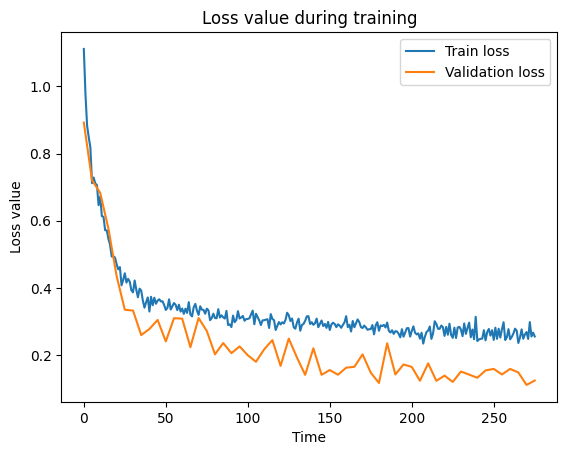

In [48]:
# PLOT THE TRAIN AND VALIDATION LOSSES THROUGH THE EPOCHS
regression_net.plot_train_loss()
# plt.ylim(-1, 4000)

## Testing and visualisation

Loss: 0.1887
Number of images: 9


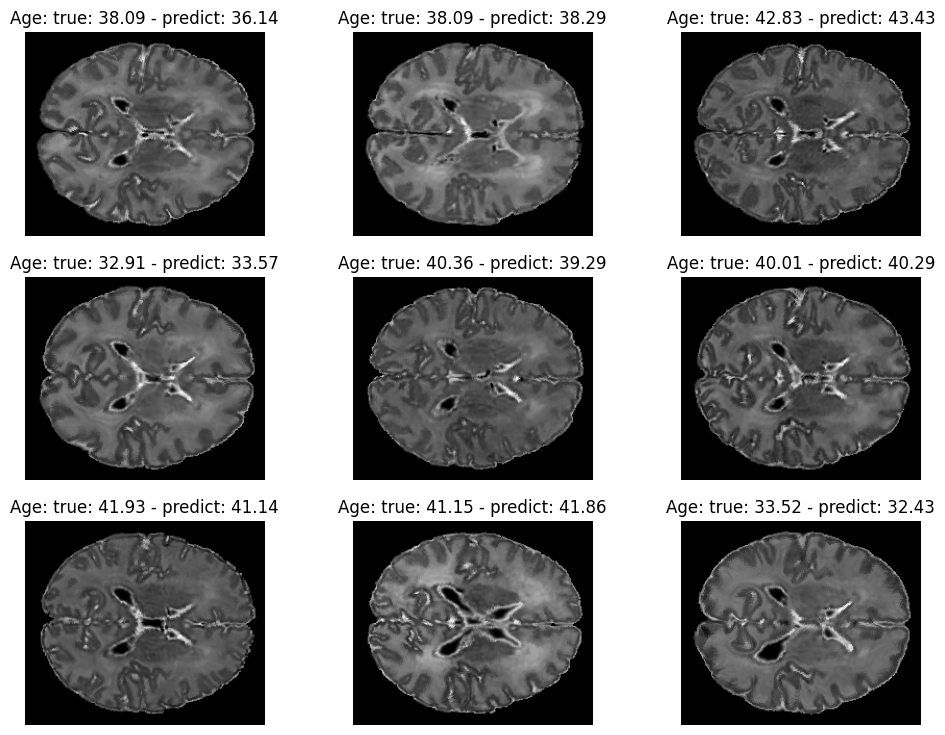

Absolute error: Mean: 0.8160679936408997 - Std 0.5201470255851746


In [49]:
# TEST YOUR MODEL:
regression_net.test(test_loader)

# DISPLAY INPUT IMAGES AND PREDICTED AGE VS. GROUND-TRUTH AGE FOR THE SUBJECTS IN YOUR TEST SET
# Get the sample and predict
input, output = next(iter(test_loader))
input=input.to(device)
predict = regression_net.model(input).cpu()
print(f"Number of images: {len(input)}")
input=input.cpu()
output = denormalize_age(output)
predict = denormalize_age(predict)
# Plot
rows = 3
columns = 3
fig = plt.figure(figsize = (12,9))
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(f'Age: true: {round((predict[i].item()),2)} - predict: {round((output[i].item()),2)}')
#     img = images[i] / 2 + 0.5     # this is to unnormalize the image
#     img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(input[i].squeeze(), cmap = "gray")
plt.show()

# CALCULATE AVERAGE AND STANDARD DEVIATION OF THE MAE OF YOUR TEST SET
mae = (output - predict).abs()
print(f"Absolute error: Mean: {mae.mean()} - Std {mae.std()}")

## Comment:
### From the loss curve, it is expected that the current model can be improved further if continued to be trained.
### SmoothL1Loss worked much better than L1Loss. As when I was training with L1Loss, the MAE got stuck and fluctate around 0.8 with no improved sign even at twice the number of epochs, the loss in sometime skyrocket (which might be due to the that that L1 Loss is non-differential at zeros).
### Swish activation help smoothen the loss compared to LeakyReLU. As when I was using LeakyReLU, the loss fluctuated a lot.
### Loss in trainning is higher than validation because of the dropout layer, which force the model to learn multiple representation of the images. And when no dropouts is active, the model is an ensemble model of smaller models with dropouts.




# **Part 3 - Variational Autoencoder (VAE)**

In this section, I will implement a Variational Autoencoder (encoder and decoder). The model is trained with the following loss functions: **SmoothL1Loss for regression**, **MSE (mean square error) for reconstruction**, and **KL Divergence for the Variational AE**.

The regression model in the previous section will be retained as the Encoder with last linear layer in the bottleneck used to predict brain age.

## Define some architecture:

PositionalEncoding: for the multi-head attention after the latent space in the decoder.

CustomReLU: ReLU but the cut-off is not zero! Used at the last layer to map pixels smaller than the background to become the background.

MaskedMSELoss and MaskedMSELoss_Simple: MSE loss but with mask applied to tackle the high proportion of background.

Encoder: the Encoder in the VAE.

KL loss: the KL loss used in the VAE.

In [50]:
class PositionalEncoding(nn.Module):
    """I copy it here https://stackoverflow.com/questions/77444485/using-positional-encoding-in-pytorch"""
    def __init__(self, embed_dim: int, dropout: float = 0.1, max_len: int = 50000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe = torch.zeros(max_len, 1, embed_dim)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

x = torch.rand((100, 17, 32))
test = PositionalEncoding(embed_dim=32, dropout=0.1)
print(f"Test {test(x).size()}")

Test torch.Size([100, 17, 32])


In [52]:
# Make the min value a little bigger to make thresholding possible
zero_pixel_after_transform = train_dataset[0][0].min().detach().item() + 0.001

class CustomReLU(nn.Module):
    """Last layer of decoder
    Make all pixels less than the zero_pixel_after_transform become zero_pixel_after_transform"""
    def __init__(self, cut_off = zero_pixel_after_transform):
        super().__init__()
        self.cut_off = torch.tensor(cut_off)
    def forward(self, x):
        x = x-self.cut_off
        return x*(x>0)+self.cut_off

test = CustomReLU()
x = (torch.rand((3,4))-0.5)*20
print(x)
print(f"test: {test(x)}")
print(zero_pixel_after_transform)

# MSE loss with mask
class MaskedMSELoss(nn.Module):
    def __init__(self, cut_off = zero_pixel_after_transform, non_zero_weight = 1.0, zero_weight = 0.0):
        super().__init__()
        self.cut_off = torch.tensor(cut_off)
        self.non_zero_weight = non_zero_weight
        self.zero_weight = zero_weight

    def forward(self, output, target):
        """
        Calculates the mse loss function, where 0 pixels is not consider in the mean.
        Args:
            output (torch.Tensor): The model's output.
            target (torch.Tensor): The ground truth target.
        Returns:
            torch.Tensor: The calculated loss.
        """
        loss = (output-target)**2
        loss_non_zero = loss[target>self.cut_off]
        loss_zero = loss[target<=self.cut_off]
        return self.non_zero_weight*loss_non_zero.mean() + self.zero_weight*loss_zero.mean()
   
# MSE loss with mask
class MaskedMSELoss_Simple(nn.Module):
    def __init__(self, cut_off = zero_pixel_after_transform):
        super().__init__()
        self.cut_off = torch.tensor(cut_off)

    def forward(self, output, target):
        """
        Simplier version to speed up initial training
        Calculates the mse loss function, where 0 pixels is not consider in the mean.
        Args:
            output (torch.Tensor): The model's output.
            target (torch.Tensor): The ground truth target.
        Returns:
            torch.Tensor: The calculated loss.
        """
        loss = (output-target)**2
        loss_non_zero = loss[target>self.cut_off]
        return loss_non_zero.mean()

x = torch.tensor([[1, 1.0, 1, 1, 1],[1, 1, 1, 1, 1]])
y = torch.tensor([[0, 0, 0, 0, 0],[-3.47, -3.47, 0, 0.0, 0]])

test=MaskedMSELoss(cut_off = zero_pixel_after_transform, non_zero_weight = 0.5, zero_weight = 0.5)
print(f"test {test(x,y)}")

tensor([[ 7.1817, -8.7794, -7.3595,  0.1974],
        [-6.7128,  2.5577, -4.3235,  7.3873],
        [-2.8419,  2.2160,  3.6828, -6.6391]])
test: tensor([[ 7.1817, -3.4656, -3.4656,  0.1974],
        [-3.4656,  2.5577, -3.4656,  7.3873],
        [-2.8419,  2.2160,  3.6828, -3.4656]])
-3.4656035175323487
test 10.490450859069824


In [53]:
# DEFINE YOUR DECODER ARCHITECTURE MODEL TO RECONSTRUCT THE IMAGE
class Decoder(nn.Module):
    def __init__(self, in_channels=512, input_image_size=[25, 29], output_image_size=[196, 230], depth=4, length=1, complexity=32,
                 out_channels=1, activation_func=nn.LeakyReLU, attention_dropout=0.1, zero_pixel_after_transform = zero_pixel_after_transform):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        depth - integer: how many time the network downsample the image
        length - integr: how many CNN will the image underwent before downsampled,
        latent_size - integer: length of latent vector,
        complexity - integer: no of channels of first convolution
        """
        super().__init__()
        # Assert that the image could be downsampled with given depth
        output_image_size = torch.tensor(output_image_size)
        assert torch.log2(output_image_size).min() > depth, "The network might not be able to downsample the image to such depth"
        assert type(activation_func) == type, f"activation_func {activation_func} should be a class"
        # Store the input size
        self.input_image_size = [int(i) for i in input_image_size]
        # Declare the dict for encoder
        decoder = OrderedDict()
                
        # First layer
        feature_size = complexity*2**depth
        self.first_layer_to_increase_no_channels = nn.Sequential(
            ResBlock(
                in_channels = in_channels,
                out_channels = feature_size,
                kernel_size = 3,
                mode = "level",
                activation_func = activation_func,
            ),
            nn.BatchNorm2d(feature_size),
            activation_func(),
            nn.Dropout(),
        )
        
        # Attention layer to introduce some spatial variance for a network with all conv layer
        # The output of the conv layer is (bacth, feature_size, *image_size)
        # The input of the attention layer is (bacth, seq_size = image_size, embed_dim = feature_size)
        self.first_positional_encoding = PositionalEncoding(embed_dim=feature_size, dropout=attention_dropout)
        self.first_multiheadattention = nn.MultiheadAttention(embed_dim=feature_size,
                                                              num_heads=feature_size//complexity,
                                                              batch_first=False,
                                                              dropout=attention_dropout)
        self.activation_after_multiheadattention_and_reshape = nn.Sequential(
            nn.BatchNorm2d(feature_size),
            activation_func(),
            nn.Dropout(),
        )

        
        # For each depth, the network go into a length number of resnet before downsampled
        for d in range(0, depth, 1):
            # Reset in_channels and doubling the feature_size
            in_channels = feature_size
            feature_size //= 2
            # Extract more features in this depth
            for l in range(0, length - 1, 1):
                decoder["decoder-depth_"+str(d)+"-length_"+str(l)] = nn.Sequential(
                    ResBlock(
                        in_channels = in_channels,
                        out_channels = in_channels,
                        kernel_size = 3,
                        mode = "level",
                        activation_func = activation_func,
                    ),
                    nn.BatchNorm2d(in_channels),
                    activation_func(),
                    nn.Dropout(),
                )
            # Upsampling
            decoder["decoder-depth_"+str(d)+"-upsample"] = nn.Sequential(
                ResBlock(
                    in_channels = in_channels,
                    out_channels = feature_size,
                    mode = "upsample",
                    activation_func = activation_func,
                ),
                nn.BatchNorm2d(feature_size),
                activation_func(),
                nn.Dropout(),
            )
        # Last layer
        decoder["last_layer_with_no_activation"] = nn.Sequential(
            ResBlock(
                in_channels = feature_size,
                out_channels = out_channels,
                kernel_size = 3,
                mode = "level",
                activation_func = activation_func,
            ),
            CustomReLU(cut_off = zero_pixel_after_transform),
        )
        self.decoder = nn.Sequential(decoder)
        self.image_height = int(output_image_size[0])
        self.image_width = int(output_image_size[1])

    def forward(self, x):
        x = self.first_layer_to_increase_no_channels(x)
        # The output of the conv layer is (batch, feature_size, *image_size)
        # The input of the attention layer is (seq_size = image_size, batch, embed_dim = feature_size)
        x = x.flatten(start_dim=2).permute(2,0,1)
        x = self.first_positional_encoding(x) + x
        x, _ = self.first_multiheadattention(x, x, x)
        x = x.permute(1,2,0)
        x = self.activation_after_multiheadattention_and_reshape(x.view(x.size(0), x.size(1), *self.input_image_size))
        # Back to the decoder
        x = self.decoder(x)
        start_height = (x.size(-2)-self.image_height)//2
        start_width = (x.size(-1)-self.image_width)//2
        x = x[:,:,start_height:start_height+self.image_height,start_width:start_width+self.image_width]
        return x

# Test
in_channels=4
input_image_size = [25, 29]
output_image_size = [196, 230]
depth = 3
length = 1
complexity= 32
out_channels = 1
attention_dropout=0.3
zero_pixel_after_transform=zero_pixel_after_transform
test = Decoder(in_channels=in_channels, input_image_size=input_image_size, output_image_size=output_image_size, depth=depth, length=length,
               complexity=complexity, out_channels=out_channels, activation_func=Swish, attention_dropout=attention_dropout, zero_pixel_after_transform=zero_pixel_after_transform)

x = torch.rand((3, in_channels, *input_image_size))
print(x.size())
print(test(x).size())
total_params = sum(p.numel() for p in test.parameters())
print(f"Total number of parameters: {total_params}")

torch.Size([3, 4, 25, 29])
torch.Size([3, 1, 196, 230])
Total number of parameters: 2445678


In [54]:
# DEFINE YOUR ENCODER-DECODER ARCHITECTURE MODEL TO OUTPUT RECONSTRUCTED IMAGE AND PREDICT BRAIN AGE IN THE LATENT SPACE
# Function to calculate KL loss
def calculate_KL_loss(mu, logvar):
    return -0.5*(1 + logvar - mu**2 - torch.exp(logvar)).mean()

class KL_loss_vector(nn.Module):
    """ The mean is moved into the training to make sure parallel computing do not stack results from different GPU into the model"""
    def __init__(self):
        super().__init__()
    def forward(self, mu, logvar):
        return -0.5*(1 + logvar - mu**2 - torch.exp(logvar))

# Decoder
class VAE(nn.Module):
    def __init__(self, in_channels=1, image_size=[196, 230], depth=4, length=1, encoder_complexity = 32, decoder_complexity = 32, latent_channels=32*4 , classifer_dim=[64, 1],
                 decoder_length = length+2, out_channels=1, activation_func=nn.LeakyReLU, attention_dropout=0.1, zero_pixel_after_transform=zero_pixel_after_transform):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        depth - integer: how many time the network downsample the image
        length - integr: how many CNN will the image underwent before downsampled,
        classifer_dim - list: dimension of hidden and last layer
        """
        assert type(activation_func) == type, f"activation_func {activation_func} should be a class"
        super().__init__()
        # Encoder layer
        self.encoder = Encoder(in_channels=in_channels, image_size=image_size, depth=depth, length=length, complexity=encoder_complexity,
                               latent_channels=latent_channels, activation_func=activation_func, attention_dropout=attention_dropout)
        self.encoder_activation = activation_func()

        number_of_linear_node = int(self.encoder.output_size.prod())
        print(f"Latent size: {self.encoder.output_size}")
        latent_channels = int(self.encoder.output_size[0])
        # Encoder to mu and logvar
        self.mu = nn.Conv2d(
            in_channels=latent_channels,
            out_channels=latent_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.logvar = nn.Conv2d(
            in_channels=latent_channels,
            out_channels=latent_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        # KL loss
        self.calculate_KL_loss_vector = KL_loss_vector()
        # Decoder layer
        self.decoder = Decoder(in_channels=latent_channels, input_image_size=self.encoder.output_size[1:3],
                               output_image_size=image_size, depth=depth, complexity=decoder_complexity,
                               length=decoder_length, out_channels=out_channels, activation_func=activation_func,
                               attention_dropout=attention_dropout, zero_pixel_after_transform=zero_pixel_after_transform)

        # Linear map to latent space
        # Classifier layer for multitask learning
        if len(classifer_dim)>1:
            self.classifier = nn.Sequential(
                MLP([number_of_linear_node, *classifer_dim[:-1]], activation_func=activation_func),
                nn.BatchNorm1d(classifer_dim[-2]),
                activation_func(),
                nn.Dropout(),
                nn.Linear(classifer_dim[-2],classifer_dim[-1]),
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(number_of_linear_node,classifer_dim[-1]),
            )

        self.classification_output = 0
        self.latent_KL_loss_vector = 0
        
        # Initiate the weights
        self.initialize_weights()
        
        # Print number of parameters
        total_params = sum(p.numel() for p in self.encoder.parameters())
        print(f"Encoder number of parameters: {total_params}")
        total_params = sum(p.numel() for p in self.classifier.parameters())
        print(f"Classifier number of parameters: {total_params}")
        total_params = sum(p.numel() for p in self.decoder.parameters())
        print(f"Decoder number of parameters: {total_params}")
        
    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d,
                                   nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d,
                                   nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
        
    def forward(self, x):
        # Encoder
        x = self.encoder_activation(self.encoder(x))
        mu = self.mu(x)
        logvar = self.logvar(x)

        # Calculate DL loss
        self.latent_KL_loss_vector = self.calculate_KL_loss_vector(mu, logvar)

        # Classifier
        self.classification_output = self.classifier(torch.flatten(mu, start_dim = 1))

        # Sampling
        if self.training:
            x = mu + torch.exp(0.5*logvar)*torch.randn_like(logvar)
        else:
            x = mu

        # Decoder
        x = self.decoder(x)

        return x, self.latent_KL_loss_vector, self.classification_output,

    def reconstruct(self, x):
        # Encoder
        x = self.encoder_activation(self.encoder(x))
        mu = self.mu(x)
        x = mu
        x = self.decoder(x)
        return x

# Test
in_channels = 1
image_size = [196, 230]
depth = 3
length = 1
encoder_complexity = 32
decoder_complexity = 32
latent_channels = 4
classifer_dim=[64, 64, 1]
out_channels=1
decoder_length=1
activation_func=Swish
attention_dropout=0.3
zero_pixel_after_transform=zero_pixel_after_transform
test = VAE(in_channels=in_channels, image_size=image_size, depth=depth, length=length, encoder_complexity=encoder_complexity, decoder_complexity=decoder_complexity,
           latent_channels=latent_channels, classifer_dim=classifer_dim, out_channels=out_channels, decoder_length=decoder_length, activation_func=activation_func,
           attention_dropout=attention_dropout, zero_pixel_after_transform=zero_pixel_after_transform)

x = torch.rand((3, 1, *image_size))
print(x.size())
print(test(x)[0].size())
print(test.classification_output.size())
print(test.latent_KL_loss_vector.size())
total_params = sum(p.numel() for p in test.parameters())
print(f"Total number of parameters: {total_params}")

Latent size: tensor([ 4, 25, 29], dtype=torch.int32)
Encoder number of parameters: 389380
Classifier number of parameters: 190145
Decoder number of parameters: 2445678
torch.Size([3, 1, 196, 230])
torch.Size([3, 1, 196, 230])
torch.Size([3, 1])
torch.Size([3, 4, 25, 29])
Total number of parameters: 3025499


## Model wrapper for train val and test

In [55]:
# TRAIN YOUR MODEL TO GENERATE THE BRAIN IMAGES AND ESTIMATE BRAIN AGE USING THE GROUND-TRUTH AGE LABELS FOR EACH IMAGE
# TRAINING LOOP:
# Create a class that aid in training and testing
class VAE_Model_Wrapper:
    def __init__(self, model, optimizer, contruction_loss_function, regression_loss_function,
                 device, save_file = "model_parameter.pth"):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.contruction_loss_function = contruction_loss_function
        self.regression_loss_function = regression_loss_function
        self.device = device
        self.total_train_epoch = 0
        self.loss_list = {"train": {"Reconstruction_loss": [], "KL_loss": [], "Regression_loss": [], "Epoch": []},
                          "val": {"Reconstruction_loss": [], "KL_loss": [], "Regression_loss": [], "Epoch": []}} # [[[train loss], [epoch]],[[val loss], [epoch]]
        self.calculated_metrics = None
        # Variable to store model
        self.save_file = save_file
        self.min_val_loss = float("inf")
        self.best_epoch = 0

    def push_to_device(self):
        # Handle cases where multiple and single gpus are available
        self.parallel_model = self.model
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            self.parallel_model = nn.DataParallel(self.model)
        self.parallel_model.to(self.device)

    def train(self, num_epochs, train_loader, val_loader, val_period=1, weights=[1.0, 1.0, 1.0]):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(self.total_train_epoch, expected_total_epoch):
            # Train loop
            self.parallel_model.train()
            reconstruction_loss_storage = []
            KL_loss_storage = []
            regression_loss_storage = []
            for i, (input, output) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                input = input.to(self.device)
                output = output.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                result, latent_KL_loss, classification_output = self.parallel_model(input)
                # Calculate the loss
                reconstruction_loss = self.contruction_loss_function(result, input)
                KL_loss = latent_KL_loss.mean()
                regression_loss = self.regression_loss_function(classification_output, output)
                loss =  weights[0]*reconstruction_loss + weights[1]*KL_loss + weights[2]*regression_loss**2
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                reconstruction_loss_storage.append(reconstruction_loss.detach().item())
                KL_loss_storage.append(KL_loss.detach().item())
                regression_loss_storage.append(regression_loss.detach().item())
            reconstruction_loss_storage = torch.tensor(reconstruction_loss_storage).mean().item()
            KL_loss_storage = torch.tensor(KL_loss_storage).mean().item()
            regression_loss_storage = torch.tensor(regression_loss_storage).mean().item()
            self.loss_list["train"]["Reconstruction_loss"].append(reconstruction_loss_storage)
            self.loss_list["train"]["KL_loss"].append(KL_loss_storage)
            self.loss_list["train"]["Regression_loss"].append(regression_loss_storage)
            self.loss_list["train"]["Epoch"].append(epoch)
            if epoch % val_period == 0:
                # Validate loop
                self.parallel_model.eval()
                # Store loss from training
                reconstruction_loss_train = reconstruction_loss_storage
                KL_loss_train = KL_loss_storage
                regression_loss_train = regression_loss_storage
                train_total_loss = weights[0]*reconstruction_loss_train + weights[1]*KL_loss_train + weights[2]*regression_loss_train**2
                # Initiate storage for new loop
                reconstruction_loss_storage = []
                KL_loss_storage = []
                regression_loss_storage = []
                for i, (input, output) in enumerate(val_loader, 0):
                    # Push data to GPU, clear gradient, calculate loss, backpropagation
                    input = input.to(self.device)
                    output = output.to(self.device)
                    # Forward
                    result, latent_KL_loss, classification_output = self.parallel_model(input)
                    # Calculate the loss
                    reconstruction_loss = self.contruction_loss_function(result, input)
                    KL_loss = latent_KL_loss.mean()
                    regression_loss = self.regression_loss_function(classification_output, output)
                    # Store the loss value
                    reconstruction_loss_storage.append(reconstruction_loss.detach().item())
                    KL_loss_storage.append(KL_loss.detach().item())
                    regression_loss_storage.append(regression_loss.detach().item())
                reconstruction_loss_storage = torch.tensor(reconstruction_loss_storage).mean().item()
                KL_loss_storage = torch.tensor(KL_loss_storage).mean().item()
                regression_loss_storage = torch.tensor(regression_loss_storage).mean().item()
                val_total_loss = weights[0]*reconstruction_loss_storage + weights[1]*KL_loss_storage + weights[2]*regression_loss_storage**2
#                 # Store the model parameters if we get the minimal loss (avoid over fitting)
#                 if val_total_loss < self.min_val_loss:
#                     torch.save(self.model.module.state_dict(), self.save_file)
#                     self.min_val_loss = val_total_loss
#                     self.best_epoch = epoch+1
                self.loss_list["val"]["Reconstruction_loss"].append(reconstruction_loss_storage)
                self.loss_list["val"]["KL_loss"].append(KL_loss_storage)
                self.loss_list["val"]["Regression_loss"].append(regression_loss_storage)
                self.loss_list["val"]["Epoch"].append(epoch)
                # print the loss
                print(f"Epoch {epoch+1}/{expected_total_epoch}. Total_loss_train {round(train_total_loss,3)}, Total_loss_val {round(val_total_loss,3)}:")
                print(f"Train: Reconstruction {round(reconstruction_loss_train,3)}; KL {round(KL_loss_train,3)}; Regression {round(regression_loss_train,3)}")
                print(f"Val:   Reconstruction {round(reconstruction_loss_storage,3)}; KL {round(KL_loss_storage,3)}; Regression {round(regression_loss_storage,3)}")
                self.parallel_model.train()
            self.total_train_epoch += 1
        return reconstruction_loss_storage, KL_loss_storage, regression_loss_storage        

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
        train_epoch = np.array(self.loss_list["train"]["Epoch"])
        val_epoch = np.array(self.loss_list["val"]["Epoch"])

        ax = axes[0]
        # Reconstruction_loss
        loss_name = "Reconstruction_loss"
        train_loss = np.array(self.loss_list["train"][loss_name])
        val_loss = np.array(self.loss_list["val"][loss_name])
        ax.plot(train_epoch, train_loss, label = "Train loss")
        ax.plot(val_epoch, val_loss, label = "Validation loss")
        # Add a title and labels
        ax.set_title(loss_name)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')
        ax.legend()

        ax = axes[1]
        # KL_loss
        loss_name = "KL_loss"
        train_loss = np.array(self.loss_list["train"][loss_name])
        val_loss = np.array(self.loss_list["val"][loss_name])
        ax.plot(train_epoch, train_loss, label = "Train loss")
        ax.plot(val_epoch, val_loss, label = "Validation loss")
        # Add a title and labels
        ax.set_title(loss_name)
        ax.set_xlabel('Time')
#         ax.set_ylabel('Loss value')
        ax.legend()

        ax = axes[2]
        # Regression_loss
        loss_name = "Regression_loss"
        train_loss = np.array(self.loss_list["train"][loss_name])
        val_loss = np.array(self.loss_list["val"][loss_name])
        ax.plot(train_epoch, train_loss, label = "Train loss")
        ax.plot(val_epoch, val_loss, label = "Validation loss")
        # Add a title and labels
        ax.set_title(loss_name)
        ax.set_xlabel('Time')
#         ax.set_ylabel('Loss value')
        ax.legend()

    def test(self, test_loader):
        """Test on test data set"""
        # Test the model
        self.parallel_model.eval()
        # Initiate storage for new loop
        reconstruction_loss_storage = []
        KL_loss_storage = []
        regression_loss_storage = []
        for i, (input, output) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            input = input.to(device)
            output = output.to(device)
            # Predict
            result, latent_KL_loss, classification_output = self.parallel_model(input)
            # Calculate the loss
            reconstruction_loss = self.contruction_loss_function(result, input)
            KL_loss = latent_KL_loss.mean()
            regression_loss = self.regression_loss_function(classification_output, output)
            # Store the loss value
            reconstruction_loss_storage.append(reconstruction_loss.detach().item())
            KL_loss_storage.append(KL_loss.detach().item())
            regression_loss_storage.append(regression_loss.detach().item())
            # Calculate performance
            self.calculate_metrics(result, output)
        # print the loss and metrics
        reconstruction_loss_storage = torch.tensor(reconstruction_loss_storage).mean().item()
        KL_loss_storage = torch.tensor(KL_loss_storage).mean().item()
        regression_loss_storage = torch.tensor(regression_loss_storage).mean().item()
        test_total_loss = reconstruction_loss_storage + KL_loss_storage + regression_loss_storage
        print(f"Loss {round(test_total_loss,3)}: reconstruction {round(reconstruction_loss_storage,3)} KL {round(KL_loss_storage,3)} regression {round(regression_loss_storage,3)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def save_model(self, save_file=None):
        if save_file is None:
            if torch.cuda.device_count() > 1:
                torch.save(self.parallel_model.module.state_dict(), self.save_file)
            else:
                torch.save(self.parallel_model.state_dict(), self.save_file)
            return
        else:
            if torch.cuda.device_count() > 1:
                torch.save(self.parallel_model.module.state_dict(), save_file)
            else:
                torch.save(self.parallel_model.state_dict(), save_file)
            return

    def calculate_metrics(self, labels, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        if (self.calculated_metrics == None):
            self.calculated_metrics = {}

In [56]:
# Model
in_channels = 1
image_size = [196, 230]
depth = 4
length = 1
encoder_complexity = 32
decoder_complexity = 16
latent_channels = 32
classifer_dim=[32, 32, 1]
out_channels=1
decoder_length=1
activation_func=Swish
attention_dropout=0.1
zero_pixel_after_transform=zero_pixel_after_transform


model_VAE = VAE(in_channels=in_channels, image_size=image_size, depth=depth, length=length,
                encoder_complexity=encoder_complexity, decoder_complexity=decoder_complexity,
                latent_channels=latent_channels, classifer_dim=classifer_dim,
                out_channels=out_channels, decoder_length=decoder_length, activation_func=activation_func,
                attention_dropout=attention_dropout, zero_pixel_after_transform=zero_pixel_after_transform)

total_params = sum(p.numel() for p in model_VAE.parameters())
print(f"Total number of parameters: {total_params}")
# Optimizer
beta1 = 0.9
beta2 = 0.999
lr = 0.001
optimizer = optim.Adam(model_VAE.parameters(), lr=lr, betas=(beta1, beta2))
# Loss function
# contruction_loss_function = nn.MSELoss()
contruction_loss_function = MaskedMSELoss_Simple(cut_off = zero_pixel_after_transform)
regression_loss_function = nn.SmoothL1Loss(beta=0.1)
# Model wrapper
save_file = os.path.join(root_path,'VAE_parameters.pth')
save_file = os.path.join('/kaggle/working','VAE_parameters.pth')
net_VAE = VAE_Model_Wrapper(model_VAE, optimizer, contruction_loss_function, regression_loss_function, device, save_file)
net_VAE.push_to_device()

Latent size: tensor([32, 13, 15], dtype=torch.int32)
Encoder number of parameters: 1718272
Classifier number of parameters: 200929
Decoder number of parameters: 2593214
Total number of parameters: 4530911
Using 2 GPUs!


In [58]:
# Train model
net_VAE.train(200, train_loader, val_loader, val_period=5, weights=[1, 0.5, 0.5])

Epoch 6/203. Total_loss_train 1.602, Total_loss_val 1.598:
Train: Reconstruction 1.257; KL 0.07; Regression 0.787
Val:   Reconstruction 1.291; KL 0.112; Regression 0.709
Epoch 11/203. Total_loss_train 1.354, Total_loss_val 2.062:
Train: Reconstruction 1.101; KL 0.072; Regression 0.659
Val:   Reconstruction 1.764; KL 0.045; Regression 0.742
Epoch 16/203. Total_loss_train 1.165, Total_loss_val 1.931:
Train: Reconstruction 0.984; KL 0.07; Regression 0.54
Val:   Reconstruction 1.77; KL 0.076; Regression 0.496
Epoch 21/203. Total_loss_train 1.031, Total_loss_val 1.738:
Train: Reconstruction 0.885; KL 0.06; Regression 0.482
Val:   Reconstruction 1.582; KL 0.063; Regression 0.5
Epoch 26/203. Total_loss_train 0.961, Total_loss_val 1.658:
Train: Reconstruction 0.834; KL 0.049; Regression 0.452
Val:   Reconstruction 1.576; KL 0.057; Regression 0.325
Epoch 31/203. Total_loss_train 0.938, Total_loss_val 1.204:
Train: Reconstruction 0.816; KL 0.042; Regression 0.449
Val:   Reconstruction 1.13; KL 0

(0.5597401261329651, 0.02799612656235695, 0.3681904077529907)

In [67]:
# Change the weight of zero pixels and non-zero pixels
non_zero_weight = 0.99
zero_weight = 0.01
net_VAE.contruction_loss_function = MaskedMSELoss(cut_off = zero_pixel_after_transform,
                                                  non_zero_weight = non_zero_weight,
                                                  zero_weight = zero_weight)
# Train model
net_VAE.train(50, train_loader, val_loader, val_period=5, weights=[1, 3.0, 5.0])

Epoch 261/306. Total_loss_train 1.145, Total_loss_val 0.672:
Train: Reconstruction 0.597; KL 0.011; Regression 0.32
Val:   Reconstruction 0.51; KL 0.01; Regression 0.162
Epoch 266/306. Total_loss_train 1.302, Total_loss_val 0.721:
Train: Reconstruction 0.593; KL 0.012; Regression 0.367
Val:   Reconstruction 0.514; KL 0.01; Regression 0.187
Epoch 271/306. Total_loss_train 1.222, Total_loss_val 0.638:
Train: Reconstruction 0.593; KL 0.013; Regression 0.343
Val:   Reconstruction 0.511; KL 0.013; Regression 0.132
Epoch 276/306. Total_loss_train 1.209, Total_loss_val 0.636:
Train: Reconstruction 0.597; KL 0.012; Regression 0.34
Val:   Reconstruction 0.518; KL 0.01; Regression 0.132
Epoch 281/306. Total_loss_train 1.3, Total_loss_val 0.641:
Train: Reconstruction 0.591; KL 0.011; Regression 0.368
Val:   Reconstruction 0.507; KL 0.01; Regression 0.144
Epoch 286/306. Total_loss_train 1.233, Total_loss_val 0.77:
Train: Reconstruction 0.591; KL 0.011; Regression 0.349
Val:   Reconstruction 0.515;

(0.5310431718826294, 0.009133908897638321, 0.17308740317821503)

In [70]:
net_VAE.save_model()

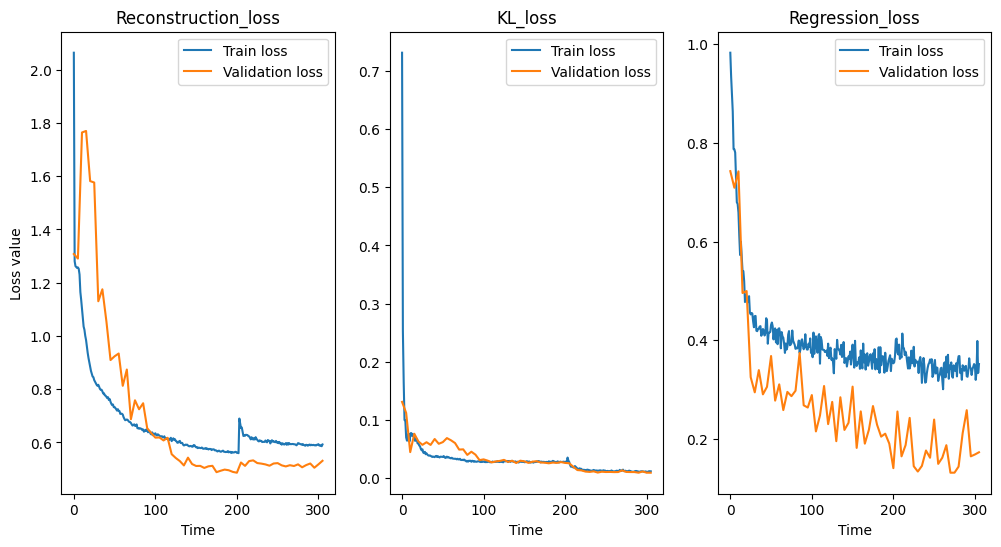

In [71]:
# PLOT THE TRAIN AND VALIDATION LOSSES THROUGH THE EPOCHS
net_VAE.plot_train_loss()

## Testing and visualisation

Loss 0.948: reconstruction 0.782 KL 0.01 regression 0.157
Number of images: 9


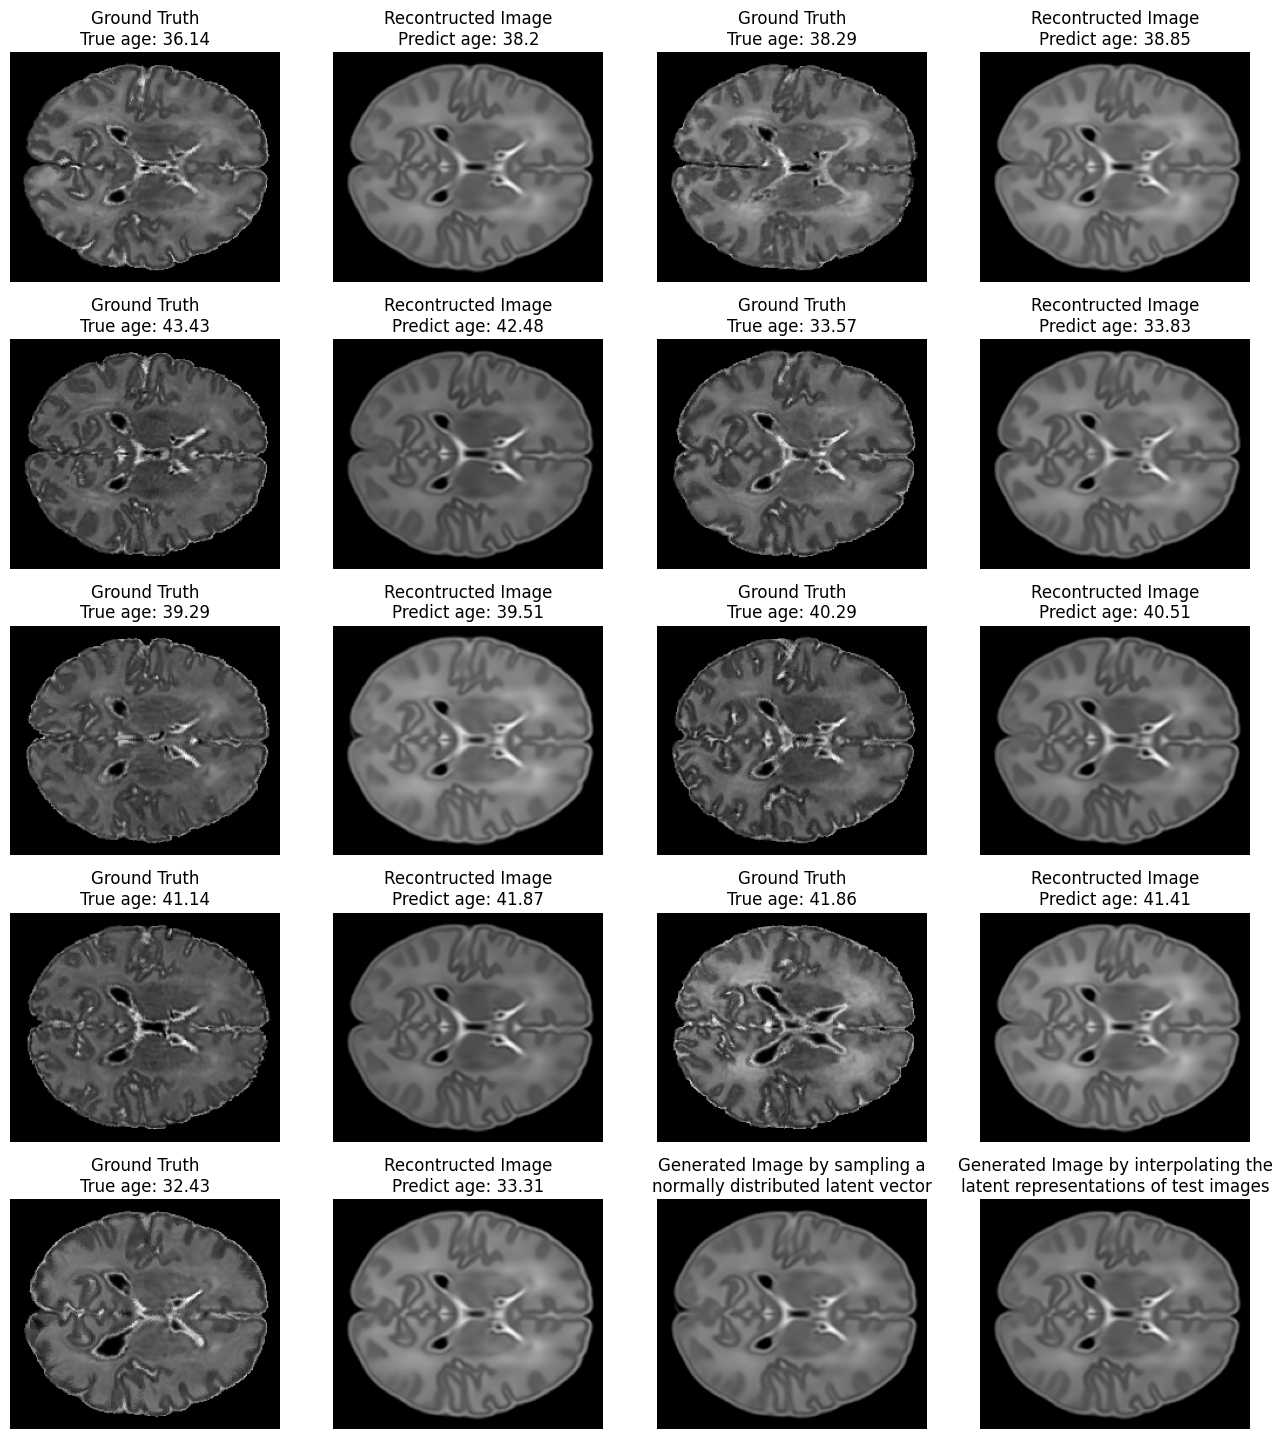

Age absolute error: Mean: 0.7041240334510803 - Std 0.5796094536781311
Reconstruction mse: Mean: 0.0018040522700175643 - Std 0.006620132364332676


In [72]:
# TEST YOUR MODEL:
net_VAE.test(test_loader)

# DISPLAY THE INPUT AND RECONSTRUCTED IMAGES PLUS THE PREDICTED AGE VS. GROUND-TRUTH AGE FOR THE SUBJECTS IN YOUR TEST SET
# Get the sample and predict
input, output = next(iter(test_loader))
input=input.to(device)
# Reconstruct the image and predict the ages
generated_images = net_VAE.model.reconstruct(input)
_, _, predict = net_VAE.model(input)
predict = predict.cpu()
print(f"Number of images: {len(input)}")
# Store two latent vectors to interpolate a new latent vector later
latent_vectors = net_VAE.model.encoder_activation(net_VAE.model.encoder(input))
latent_vectors = net_VAE.model.mu(latent_vectors)
# Create the inverse normalization transformation
denormalize = Normalize(
    mean=[-m/s for m, s in zip([image_mean], [image_std])],
    std=[1/s for s in [image_std]])
# Get the image and inverse transform
input=denormalize(input.cpu())
generated_images=denormalize(generated_images.cpu().detach())
output = denormalize_age(output)
predict = denormalize_age(predict)
# Plot
rows = 5
columns = 4
fig = plt.figure(figsize = (16,18))
for i in range(len(output)):
    fig.add_subplot(rows, columns, 2*i+1)
    plt.title(f'Ground Truth\nTrue age: {round((output[i].item()),2)}')
    plt.axis('off')
    plt.imshow(input[i].squeeze(), cmap = "gray")
    fig.add_subplot(rows, columns, 2*i+2)
    plt.title(f'Recontructed Image\nPredict age: {round((predict[i].item()),2)}')
    plt.axis('off')
    plt.imshow(generated_images[i].squeeze(), cmap = "gray")
i+=1

# Sample from latent space
z = torch.normal(0, 1, size = [1, *net_VAE.model.encoder.output_size.to(torch.int32).tolist()]).to(device)
# Interpolate in the latent space
latent_vectors = latent_vectors.mean(dim=0).unsqueeze(0)
# Combine two latent vectors
z = torch.concat([z,latent_vectors], dim=0)
sample_image = denormalize(net_VAE.model.decoder(z).cpu().detach())
fig.add_subplot(rows, columns, 2*i+1)
plt.title(f'Generated Image by sampling a\nnormally distributed latent vector')
plt.axis('off')
plt.imshow(sample_image[0].squeeze(), cmap = "gray")
fig.add_subplot(rows, columns, 2*i+2)
plt.title(f'Generated Image by interpolating the\nlatent representations of test images')
plt.axis('off')
plt.imshow(sample_image[1].squeeze(), cmap = "gray")
plt.show()


# CALCULATE AVERAGE AND STANDARD DEVIATION OF THE MAE OF BRAIN AGE OF YOUR TEST SET
# CALCULATE AVERAGE AND STANDARD DEVIATION OF THE MSE of BRAIN RECONSTRUCTION OF YOUR TEST SET#1CALCULATE AVERAGE AND STANDARD DEVIATION OF THE MAE OF YOUR TEST SET
age_mae = (output - predict).abs()
print(f"Age absolute error: Mean: {age_mae.mean()} - Std {age_mae.std()}")
reconstruction_mse = (generated_images - input)**2
print(f"Reconstruction mse: Mean: {reconstruction_mse.mean()} - Std {reconstruction_mse.std()}")

## Comment:
### From the loss curve, it is expected that the reconstruction error can be improved further if continued to be trained.
### The regression error seems to be stuck and flutuated. Futher improve is just more about fine tuning the epochs. The age error now might be due to the unexplainable variance of the data rather than the incompetency of the model (<1 week error is quite good).
### KL loss seems to work fine as when a random sample from latent space is taken, the network can generate something similar. However, improvement is still possible with further training.
### Other comments are similar to the "Age Regression Model".

# **Part 4 - VAE-WGAN**

In this section, I will define a ***Discriminator model*** and implement the adversarial learning loss.

## Define some architecture:

WassersteinLoss: use the Wasserstein distance to mitigate the gradient vanishing

compute_gradient_penalty: calculate the norm of Gradient of the last layer with respect to the input. It is added to the loss function to avoid the Discriminator outputs go to infinity when using the WassersteinLoss.

In [73]:
# Define function used for WGAN
class WassersteinLoss(nn.Module):
    """Wasserstein Loss function, implemented as:
    -ΣD(x)+ΣD(G(z)) for discriminator
    -ΣD(G(z)) for generator
    It is coded like this so it can be put into model wrapper to replace the nn.BCELoss"""
    def __init__(self):
        super().__init__()
    def forward(self, outputs, targets):
        targets=targets.mean()
        if targets==1:
            return -outputs.mean()
        elif targets==0:
            return outputs.mean()
        else:
            assert False, "targets of WassersteinLoss should be a vector of 0 or 1 only"

test = WassersteinLoss()
ones = torch.ones(4)
zeros = torch.zeros(4)
x = torch.ones(4)*5
print(test(x,ones))
print(test(x,zeros))

def compute_gradient_penalty(D, real_samples, fake_samples):
    """gradient penalty to avoid the Wasserstein skyrocket to inf when trainning"""
    # Interpolate an image between the real and fake image
    alpha = torch.rand((real_samples.size(0), 1, 1, 1)).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    # Classify the interpolated image
    d_interpolates = D(interpolates)
    # Calculate the gradient
    fake = torch.ones((real_samples.shape[0], 1), requires_grad=False).to(real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)

    # Calculate the gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

tensor(-5.)
tensor(5.)


## Add some augmentation specific to the discriminator

After trials and errors, I found that the discriminator overfitted a lot, which is why I added this.


torch.Size([9, 1, 147, 172])


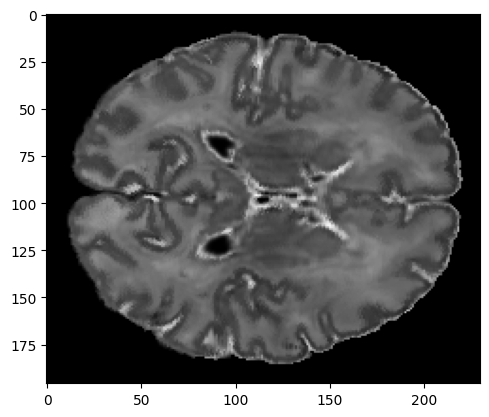

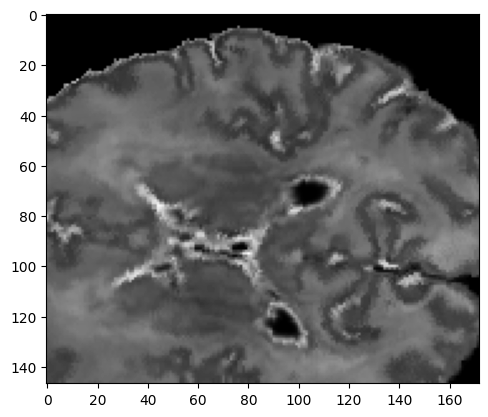

In [74]:
# Random crop for discriminator data augmentation
from torchvision import transforms
image_size=[196, 230]
discriminator_augmented_image_size = (image_size[0]*3//4, image_size[1]*3//4)
# Define the discriminator augmentaion transform
discriminator_augmentation_transform = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=5, fill=zero_pixel_after_transform),
    transforms.RandomCrop(size=discriminator_augmented_image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
]) 
# Apply the transform to an image
input, output = next(iter(test_loader))
cropped_image = discriminator_augmentation_transform(input)
print(cropped_image.size())
plt.imshow(input[0,0], cmap="gray")
plt.show()
plt.imshow(cropped_image[0,0], cmap="gray")

## Discriminator network

In [75]:
from torchvision import transforms
# DEFINE YOUR DISCRIMINATOR MODEL
class Discriminator(EncoderClassifier):
    def __init__(self, in_channels=1, image_size=[196, 230],
                 depth=4, length=1, complexity = 32, last_layer_channels=32*4,
                 classifer_dim=[64, 1], activation_func=nn.LeakyReLU, attention_dropout=0.1):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        depth - integer: how many time the network downsample the image
        length - integr: how many CNN will the image underwent before downsampled,
        classifer_dim - list: dimension of hidden and last layer
        """
        assert type(activation_func) == type, f"activation_func {activation_func} should be a class"
        assert classifer_dim[-1] == 1, "The last number in classifer_dim should be 1 for a GAN network"
        discriminator_augmented_image_size = (image_size[0], image_size[1])
        super().__init__(in_channels=in_channels, image_size=discriminator_augmented_image_size,
                         depth=depth, length=length, complexity = complexity, latent_channels=last_layer_channels,
                         classifer_dim=classifer_dim, activation_func=activation_func,
                         attention_dropout=attention_dropout)
        
     
    def forward(self, x):
        # Perform augmentation
        return super().forward(x)

# Test
in_channels = 1
image_size = [196, 230]
discriminator_augmented_image_size = (image_size[0]*3//4, image_size[1]*3//4)
depth = 5
length = 2
complexity = 32
last_layer_channels=complexity*depth #latent_channels
classifer_dim=[64,64,1]
activation_func=Swish
attention_dropout=0.1
test = Discriminator(in_channels=in_channels, image_size=discriminator_augmented_image_size, depth=depth, length=length,
                     complexity=complexity, last_layer_channels=last_layer_channels, classifer_dim=classifer_dim,
                     activation_func=activation_func, attention_dropout=attention_dropout)

x = torch.rand((3, 1, *image_size))
x = discriminator_augmentation_transform(x)
print(x.size())
print(test(x).size())

torch.Size([3, 1, 147, 172])
torch.Size([3, 1])


In [76]:
# TRAIN YOUR VAE-GAN AS BEFORE TO GENERATE THE BRAIN IMAGES AND ESTIMATE BRAIN AGE: NOW YOU WILL NEED TO ADD THE DISCRIMINATOR AND ADVERSARIAL LOSS TO YOUR TRAINING LOOP
# TRAINING LOOP:
# Create a class that aid in training and testing
class VAE_GAN_Model_Wrapper:
    def __init__(self, generator_model, discriminator_model, generator_optimizer, discriminator_optimizer, contruction_loss_function, regression_loss_function,
                 adversarial_loss_function, device, save_files = "model_parameter.pth"):
        '''Start the model and store important object'''
        self.generator_model = generator_model
        self.discriminator_model = discriminator_model
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.contruction_loss_function = contruction_loss_function
        self.regression_loss_function = regression_loss_function
        self.adversarial_loss_function = adversarial_loss_function
        self.device = device
        # Store the size of the latent space
        self.latent_space_dim = self.generator_model.encoder.output_size.to(torch.int32).tolist()
        # Keep track of number of epoch
        self.train_epoch = 0
        self.train_generator_epoch = 0
        self.train_discriminator_epoch = 0
        self.val_epoch = 0
        # Keep track of the loss
        self.discriminator_train_accuracy = 0
        self.loss_list = {"generator_train": {"Reconstruction_loss": [0], "KL_loss": [0],
                                              "Regression_loss": [0], "Adversarial_loss": [0],
                                              "Epoch": [0]},
                          "generator_val": {"Reconstruction_loss": [0], "KL_loss": [0],
                                            "Regression_loss": [0], "Adversarial_loss": [0],
                                            "Epoch": [0]},
                          "discriminator_train": {"Adversarial_loss_real": [0], "Adversarial_loss_fake": [0],
                                                  "Gradient_penalty": [0], "Accuracy": [0], "Epoch": [0]},
                          "discriminator_val": {"Adversarial_loss_real": [0], "Adversarial_loss_fake": [0], 
                                                "Gradient_penalty": [0], "Accuracy": [0], "Epoch": [0]},} # [[[train loss], [epoch]],[[val loss], [epoch]]
        self.calculated_metrics = None
        # Variable to store model
        self.save_files = save_files
        self.min_val_loss = float("inf")
        self.best_epoch = 0

    def push_to_device(self):
        """Push to device"""
        # Handle cases where multiple and single gpus are available
        self.parallel_generator_model = self.generator_model
        self.parallel_discriminator_model = self.discriminator_model
        self.decoder = self.parallel_generator_model.decoder
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            self.parallel_generator_model = nn.DataParallel(self.generator_model)
            self.parallel_discriminator_model = nn.DataParallel(self.discriminator_model)
            self.decoder = self.parallel_generator_model.module.decoder
        self.parallel_generator_model.to(self.device)
        self.parallel_discriminator_model.to(self.device)

    def train_generator(self, train_loader, weights=[1.0, 1.0, 1.0, 1.0]):
        '''Train generator model'''
        # Start training
        # Train loop
        self.parallel_generator_model.train()
        self.parallel_discriminator_model.eval()
        reconstruction_loss_storage = []
        KL_loss_storage = []
        regression_loss_storage = []
        adversarial_loss_storage = []
        for i, (real_images, real_labels) in enumerate(train_loader, 0):
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            real_images = real_images.to(self.device)
            real_labels = real_labels.to(self.device)
            ones_vector = torch.ones((len(real_labels),1)).to(self.device)
            # Zero gradient
            self.generator_optimizer.zero_grad()
            # Generate the image
            generated_images, latent_KL_loss, classification_output = self.parallel_generator_model(real_images)
            # Calculate the generator-depend loss
            reconstruction_loss = self.contruction_loss_function(generated_images, real_images)
            KL_loss = latent_KL_loss.mean()
            regression_loss = self.regression_loss_function(classification_output, real_labels)
            # Discriminate the image
            generated_images = discriminator_augmentation_transform(generated_images)
            fake_discriminator_classification = self.parallel_discriminator_model(generated_images)
#             real_discriminator_classification = self.parallel_discriminator_model(discriminator_augmentation_transform(real_images))
            adversarial_loss = self.adversarial_loss_function(fake_discriminator_classification, ones_vector)
            # Sum all the loss
            loss_generator =  weights[0]*reconstruction_loss + weights[1]*KL_loss + weights[2]*regression_loss**2 + weights[3]*adversarial_loss
            # Calculate the gradient
            loss_generator.backward()
            # Update the weight
            self.generator_optimizer.step()
            # Store the loss value
            reconstruction_loss_storage.append(reconstruction_loss.item())
            KL_loss_storage.append(KL_loss.item())
            regression_loss_storage.append(regression_loss.item())
            adversarial_loss_storage.append(adversarial_loss.item())
        reconstruction_loss_storage = torch.tensor(reconstruction_loss_storage).mean().item()
        KL_loss_storage = torch.tensor(KL_loss_storage).mean().item()
        regression_loss_storage = torch.tensor(regression_loss_storage).mean().item()
        adversarial_loss_storage = torch.tensor(adversarial_loss_storage).mean().item()
        self.loss_list["generator_train"]["Reconstruction_loss"].append(reconstruction_loss_storage)
        self.loss_list["generator_train"]["KL_loss"].append(KL_loss_storage)
        self.loss_list["generator_train"]["Regression_loss"].append(regression_loss_storage)
        self.loss_list["generator_train"]["Adversarial_loss"].append(adversarial_loss_storage)
        self.train_epoch += 1
        self.train_generator_epoch +=1
        self.loss_list["generator_train"]["Epoch"].append(self.train_epoch)   
        return reconstruction_loss_storage, KL_loss_storage, regression_loss_storage, adversarial_loss_storage

    def train_discriminator(self, train_loader, weights=[1.0]):
        '''Train discriminator model'''
        # Start training
        # Train loop
        self.parallel_discriminator_model.train()
        self.parallel_generator_model.eval()
        adversarial_loss_fake_storage = []
        adversarial_loss_real_storage = []
        gradient_penalty_storage = []
        accuracy_storage = []
        for i, (real_images, real_labels) in enumerate(train_loader, 0):
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            real_images = real_images.to(self.device)
            real_labels = real_labels.to(self.device)
            ones_vector = torch.ones((len(real_labels),1)).to(self.device)
            zeros_vector = torch.zeros((len(real_labels),1)).to(self.device)
            # Zero gradient
            self.discriminator_optimizer.zero_grad()
            # Sampling from latent space and generate the image
            generated_images, _, _ = self.parallel_generator_model(real_images)
#             z = torch.normal(0, 1, size = [len(real_labels), *self.latent_space_dim]).to(self.device)
#             generated_images = self.decoder(z)
            generated_images = generated_images.detach()
            # Discriminate the image
            generated_images = discriminator_augmentation_transform(generated_images)
            real_images = discriminator_augmentation_transform(real_images)
            fake_discriminator_classification = self.parallel_discriminator_model(generated_images)
            real_discriminator_classification = self.parallel_discriminator_model(real_images)
            # Calculate the discriminator loss
            adversarial_loss_fake = self.adversarial_loss_function(fake_discriminator_classification, zeros_vector)
            adversarial_loss_real = self.adversarial_loss_function(real_discriminator_classification, ones_vector)
            adversarial_loss = weights[0]*adversarial_loss_fake + weights[1]*adversarial_loss_real
            # Gradient penalty is only available in discriminator training
            gradient_penalty = compute_gradient_penalty(self.parallel_discriminator_model, real_images, generated_images)
#             gradient_penalty = torch.tensor([0.0]).to(self.device)
            # Calculate the accuracy
            fake_discriminator_classification = torch.sigmoid(fake_discriminator_classification.detach())
            real_discriminator_classification = torch.sigmoid(real_discriminator_classification.detach())
            # Sum all the loss
            loss_discriminator = adversarial_loss + weights[2]*gradient_penalty
            # Calculate the gradient
            loss_discriminator.backward()
            # Update the weight
            self.discriminator_optimizer.step()
            accuracy = ((fake_discriminator_classification<0.5).to(torch.float).mean()+(real_discriminator_classification>=0.5).to(torch.float).mean())/2
            # Store the loss value
            adversarial_loss_fake_storage.append(adversarial_loss_fake.item())
            adversarial_loss_real_storage.append(adversarial_loss_real.item())
            gradient_penalty_storage.append(gradient_penalty.item())
            accuracy_storage.append(accuracy.item())
        adversarial_loss_fake_storage = torch.tensor(adversarial_loss_fake_storage).mean().item()
        adversarial_loss_real_storage = torch.tensor(adversarial_loss_real_storage).mean().item()
        gradient_penalty_storage = torch.tensor(gradient_penalty_storage).mean().item()
        accuracy_storage = torch.tensor(accuracy_storage).mean().item()
        self.loss_list["discriminator_train"]["Adversarial_loss_fake"].append(adversarial_loss_fake_storage)
        self.loss_list["discriminator_train"]["Adversarial_loss_real"].append(adversarial_loss_real_storage)
        self.loss_list["discriminator_train"]["Gradient_penalty"].append(gradient_penalty_storage)
        self.loss_list["discriminator_train"]["Accuracy"].append(accuracy_storage)
        self.train_epoch += 1
        self.train_discriminator_epoch +=1
        self.loss_list["discriminator_train"]["Epoch"].append(self.train_epoch)   

        return adversarial_loss_fake_storage, adversarial_loss_real_storage, gradient_penalty_storage, accuracy_storage

    def validate_both(self, val_loader):
        '''Validate both models'''
        # Validate loop
        self.parallel_generator_model.eval()
        self.parallel_discriminator_model.eval()
        reconstruction_loss_storage = []
        KL_loss_storage = []
        regression_loss_storage = []
        generator_adversarial_loss_storage = []
        discriminator_adversarial_loss_fake_storage = []
        discriminator_adversarial_loss_real_storage = []
        gradient_penalty_storage = []
        accuracy_storage = []
        for i, (real_images, real_labels) in enumerate(val_loader, 0):
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            real_images = real_images.to(self.device)
            real_labels = real_labels.to(self.device)
            ones_vector = torch.ones((len(real_labels),1)).to(self.device)
            zeros_vector = torch.zeros((len(real_labels),1)).to(self.device)
            # Generate the image
            generated_images, latent_KL_loss, classification_output = self.parallel_generator_model(real_images)
            # Calculate the generator-depend loss
            reconstruction_loss = self.contruction_loss_function(generated_images, real_images)
            KL_loss = latent_KL_loss.mean()
            regression_loss = self.regression_loss_function(classification_output, real_labels)
            # Discriminate the image
            generated_images = discriminator_augmentation_transform(generated_images)
            real_images = discriminator_augmentation_transform(real_images)
            real_discriminator_classification = self.parallel_discriminator_model(real_images)
            fake_discriminator_classification = self.parallel_discriminator_model(generated_images)
            generator_adversarial_loss = self.adversarial_loss_function(fake_discriminator_classification, ones_vector)
            discriminator_adversarial_loss_fake = self.adversarial_loss_function(fake_discriminator_classification, zeros_vector)
            discriminator_adversarial_loss_real = self.adversarial_loss_function(real_discriminator_classification, ones_vector)
            discriminator_adversarial_loss = discriminator_adversarial_loss_fake + discriminator_adversarial_loss_real
            # Gradient penalty is only available in discriminator
            gradient_penalty = compute_gradient_penalty(self.parallel_discriminator_model, real_images, generated_images)
#             gradient_penalty = torch.tensor([0.0]).to(self.device)
            # Calculate the accuracy
            fake_discriminator_classification = torch.sigmoid(fake_discriminator_classification.detach())
            real_discriminator_classification = torch.sigmoid(real_discriminator_classification.detach())
            accuracy = ((fake_discriminator_classification<0.5).to(torch.float).mean()+(real_discriminator_classification>=0.5).to(torch.float).mean())/2
            # Store the loss value
            reconstruction_loss_storage.append(reconstruction_loss.item())
            KL_loss_storage.append(KL_loss.item())
            regression_loss_storage.append(regression_loss.item())
            generator_adversarial_loss_storage.append(generator_adversarial_loss.item())
            discriminator_adversarial_loss_fake_storage.append(discriminator_adversarial_loss_fake.item())
            discriminator_adversarial_loss_real_storage.append(discriminator_adversarial_loss_real.item())
            gradient_penalty_storage.append(gradient_penalty.item())
            accuracy_storage.append(accuracy.item())
        reconstruction_loss_storage = torch.tensor(reconstruction_loss_storage).mean().item()
        KL_loss_storage = torch.tensor(KL_loss_storage).mean().item()
        regression_loss_storage = torch.tensor(regression_loss_storage).mean().item()
        generator_adversarial_loss_storage = torch.tensor(generator_adversarial_loss_storage).mean().item()
        discriminator_adversarial_loss_fake_storage = torch.tensor(discriminator_adversarial_loss_fake_storage).mean().item()
        discriminator_adversarial_loss_real_storage = torch.tensor(discriminator_adversarial_loss_real_storage).mean().item()
        gradient_penalty_storage = torch.tensor(gradient_penalty_storage).mean().item()
        accuracy_storage = torch.tensor(accuracy_storage).mean().item()
        self.loss_list["generator_val"]["Reconstruction_loss"].append(reconstruction_loss_storage)
        self.loss_list["generator_val"]["KL_loss"].append(KL_loss_storage)
        self.loss_list["generator_val"]["Regression_loss"].append(regression_loss_storage)
        self.loss_list["generator_val"]["Adversarial_loss"].append(generator_adversarial_loss_storage)
        self.loss_list["discriminator_val"]["Adversarial_loss_fake"].append(discriminator_adversarial_loss_fake_storage)
        self.loss_list["discriminator_val"]["Adversarial_loss_real"].append(discriminator_adversarial_loss_real_storage)
        self.loss_list["discriminator_val"]["Gradient_penalty"].append(gradient_penalty_storage)
        self.loss_list["discriminator_val"]["Accuracy"].append(accuracy_storage)
        self.val_epoch += 1
        self.loss_list["generator_val"]["Epoch"].append(self.train_epoch)
        self.loss_list["discriminator_val"]["Epoch"].append(self.train_epoch)
        # print the loss
        generator_total_loss = reconstruction_loss_storage + KL_loss_storage + regression_loss_storage + generator_adversarial_loss_storage
        discriminator_total_loss = discriminator_adversarial_loss_fake_storage + discriminator_adversarial_loss_real_storage + gradient_penalty_storage
        print(f"Epoch {self.train_epoch}. Generator epoch {self.train_generator_epoch} loss {round(generator_total_loss,3)}, Discriminator epoch {self.train_discriminator_epoch} loss {round(discriminator_total_loss,3)}:")

        print(f"G-T: VAE {round(self.loss_list['generator_train']['Reconstruction_loss'][-1],3)}; \
KL {round(self.loss_list['generator_train']['KL_loss'][-1],3)}; Reg {round(self.loss_list['generator_train']['Regression_loss'][-1],3)}; \
Adv {round(self.loss_list['generator_train']['Adversarial_loss'][-1],3)}", end=" | ")

        print(f"G-V: VAE {round(reconstruction_loss_storage,3)}; KL {round(KL_loss_storage,3)}; Reg {round(regression_loss_storage,3)}; Adv {round(generator_adversarial_loss_storage,3)}",end=" | ")
        
        print(f"D-T: Fake {round(self.loss_list['discriminator_train']['Adversarial_loss_fake'][-1],3)} \
Real {round(self.loss_list['discriminator_train']['Adversarial_loss_real'][-1],3)}; \
Grad {round(self.loss_list['discriminator_train']['Gradient_penalty'][-1],3)}; Acc {round(self.loss_list['discriminator_train']['Accuracy'][-1],3)}",end=" | ")
        
        print(f"D-V: Fake {round(discriminator_adversarial_loss_fake_storage,3)} Real {round(discriminator_adversarial_loss_real_storage,3)}; Grad {round(gradient_penalty_storage,3)}; Acc {round(accuracy_storage,3)}")
        
        return reconstruction_loss_storage, KL_loss_storage, regression_loss_storage, generator_adversarial_loss_storage, discriminator_adversarial_loss_fake_storage, discriminator_adversarial_loss_real_storage, gradient_penalty_storage, accuracy_storage

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        def plot_ax(ax, loss_group, loss_name, train_epoch, val_epoch):
            train_loss = np.array(self.loss_list[loss_group+"_train"][loss_name])
            val_loss = np.array(self.loss_list[loss_group+"_val"][loss_name])
            ax.plot(train_epoch, train_loss, label = "Train loss")
            ax.plot(val_epoch, val_loss, label = "Validation loss")
            # Add a title and labels
            ax.set_title(loss_group + " " + loss_name)
            ax.set_xlabel('Time')
            ax.set_ylabel('Loss value')
            ax.legend()

        # Add plot
        _, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
        train_epoch = np.array(self.loss_list["generator_train"]["Epoch"])
        val_epoch = np.array(self.loss_list["generator_val"]["Epoch"])
        plot_ax(axes[0], "generator", "Reconstruction_loss", train_epoch, val_epoch)
        plot_ax(axes[1], "generator", "KL_loss", train_epoch, val_epoch)
        plot_ax(axes[2], "generator", "Regression_loss", train_epoch, val_epoch)
        plot_ax(axes[3], "generator", "Adversarial_loss", train_epoch, val_epoch)

        # Add plot
        _, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
        train_epoch = np.array(self.loss_list["discriminator_train"]["Epoch"])
        val_epoch = np.array(self.loss_list["discriminator_val"]["Epoch"])
        plot_ax(axes[0], "discriminator", "Adversarial_loss_fake", train_epoch, val_epoch)
        plot_ax(axes[1], "discriminator", "Adversarial_loss_real", train_epoch, val_epoch)
        plot_ax(axes[2], "discriminator", "Gradient_penalty", train_epoch, val_epoch)
        plot_ax(axes[3], "discriminator", "Accuracy", train_epoch, val_epoch)

    def test(self, test_loader):
        """Test on test data set"""
        # Test the model
        self.parallel_generator_model.eval()
        self.parallel_discriminator_model.eval()
        reconstruction_loss_storage = []
        KL_loss_storage = []
        regression_loss_storage = []
        generator_adversarial_loss_storage = []
        discriminator_adversarial_loss_fake_storage = []
        discriminator_adversarial_loss_real_storage = []
        gradient_penalty_storage = []
        accuracy_storage = []
        for i, (real_images, real_labels) in enumerate(test_loader, 0):
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            real_images = real_images.to(self.device)
            real_labels = real_labels.to(self.device)
            ones_vector = torch.ones((len(real_labels),1)).to(self.device)
            zeros_vector = torch.zeros((len(real_labels),1)).to(self.device)
            # Generate the image
            generated_images, latent_KL_loss, classification_output = self.parallel_generator_model(real_images)
            # Calculate the generator-depend loss
            reconstruction_loss = self.contruction_loss_function(generated_images, real_images)
            KL_loss = latent_KL_loss.mean()
            regression_loss = self.regression_loss_function(classification_output, real_labels)
            # Discriminate the image
            generated_images = discriminator_augmentation_transform(generated_images)
            real_images = discriminator_augmentation_transform(real_images)
            fake_discriminator_classification = self.parallel_discriminator_model(generated_images)
            real_discriminator_classification = self.parallel_discriminator_model(real_images)
            # Calculate adversarial loss
            generator_adversarial_loss = self.adversarial_loss_function(fake_discriminator_classification, ones_vector)
            discriminator_adversarial_loss_fake = self.adversarial_loss_function(fake_discriminator_classification, zeros_vector)
            discriminator_adversarial_loss_real = self.adversarial_loss_function(real_discriminator_classification, ones_vector)
            discriminator_adversarial_loss = discriminator_adversarial_loss_fake + discriminator_adversarial_loss_real
            # Gradient penalty is only available in discriminator
            gradient_penalty = compute_gradient_penalty(self.parallel_discriminator_model, real_images, generated_images)
#             gradient_penalty = torch.tensor([0.0]).to(self.device)
            # Calculate the accuracy
            fake_discriminator_classification = torch.sigmoid(fake_discriminator_classification.detach())
            real_discriminator_classification = torch.sigmoid(real_discriminator_classification.detach())
            accuracy = ((fake_discriminator_classification<0.5).to(torch.float).mean()+(real_discriminator_classification>=0.5).to(torch.float).mean())/2
            # Store the loss value
            reconstruction_loss_storage.append(reconstruction_loss.item())
            KL_loss_storage.append(KL_loss.item())
            regression_loss_storage.append(regression_loss.item())
            generator_adversarial_loss_storage.append(generator_adversarial_loss.item())
            discriminator_adversarial_loss_fake_storage.append(discriminator_adversarial_loss_fake.item())
            discriminator_adversarial_loss_real_storage.append(discriminator_adversarial_loss_real.item())
            gradient_penalty_storage.append(gradient_penalty.item())
            accuracy_storage.append(accuracy.item())
        reconstruction_loss_storage = torch.tensor(reconstruction_loss_storage).mean().item()
        KL_loss_storage = torch.tensor(KL_loss_storage).mean().item()
        regression_loss_storage = torch.tensor(regression_loss_storage).mean().item()
        generator_adversarial_loss_storage = torch.tensor(generator_adversarial_loss_storage).mean().item()
        discriminator_adversarial_loss_fake_storage = torch.tensor(discriminator_adversarial_loss_fake_storage).mean().item()
        discriminator_adversarial_loss_real_storage = torch.tensor(discriminator_adversarial_loss_real_storage).mean().item()
        gradient_penalty_storage = torch.tensor(gradient_penalty_storage).mean().item()
        accuracy_storage = torch.tensor(accuracy_storage).mean().item()
        # Sum the loss for easy visualisation
        generator_total_loss = reconstruction_loss_storage + KL_loss_storage + regression_loss_storage + generator_adversarial_loss_storage
        discriminator_total_loss = discriminator_adversarial_loss_fake_storage + discriminator_adversarial_loss_real_storage + gradient_penalty_storage
        # Print the loss and metrics
        print(f"Epoch {self.train_epoch}. Generator epoch {self.train_generator_epoch} loss {round(generator_total_loss,3)}, Discriminator epoch {self.train_discriminator_epoch} loss {round(discriminator_total_loss,3)}:")
        print(f"Generator: Reconstruction {round(reconstruction_loss_storage,3)}; KL {round(KL_loss_storage,3)}; Regression {round(regression_loss_storage,3)}; Adversarial {round(generator_adversarial_loss_storage,3)}")
        print(f"Discriminator: Adversarial fake {round(discriminator_adversarial_loss_fake_storage,3)} real {round(discriminator_adversarial_loss_real_storage,3)}; Gradient penalty {round(gradient_penalty_storage,3)}; Accuracy {round(accuracy_storage,3)}")
        return reconstruction_loss_storage, KL_loss_storage, regression_loss_storage, generator_adversarial_loss_storage, discriminator_adversarial_loss_fake_storage, discriminator_adversarial_loss_real_storage, gradient_penalty_storage, accuracy_storage

    def save_model(self, save_file=None):
        if save_file is None:
            if torch.cuda.device_count() > 1:
                torch.save(self.parallel_generator_model.module.state_dict(), self.save_files[0])
                torch.save(self.parallel_discriminator_model.module.state_dict(), self.save_files[1])
            else:
                torch.save(self.parallel_generator_model.state_dict(), self.save_files[0])
                torch.save(self.parallel_discriminator_model.state_dict(), self.save_files[1])
            return
        else:
            if torch.cuda.device_count() > 1:
                torch.save(self.parallel_generator_model.module.state_dict(), save_files[0])
                torch.save(self.parallel_discriminator_model.module.state_dict(), save_files[1])
            else:
                torch.save(self.parallel_generator_model.state_dict(), save_files[0])
                torch.save(self.parallel_discriminator_model.state_dict(), save_files[1])
            return

In [89]:
# USE MAE LOSS FOR REGRESSION ; MSE LOSS FOR RECONSTRUCTION ; KL DIVERGENCE FOR VAE; BINARY CROSS ENTROPY (BCE) FOR DISCRIMINATOR LOSS
# I'm using smooth L1 loss cause it combine both advantage of L1 and L2 loss

# Model
in_channels = 1
image_size = [196, 230]
discriminator_augmented_image_size = (image_size[0]*3//4, image_size[1]*3//4)
depth = 4
length = 1
encoder_complexity = 32
decoder_complexity = 16
latent_channels = 32
classifer_dim=[32, 32, 1]
out_channels=1
decoder_length=1
activation_func=Swish
attention_dropout=0.1
zero_pixel_after_transform=zero_pixel_after_transform

discriminator_depth = 3
discriminator_length = 1
discriminator_complexity = 64
last_layer_channels = 32
discriminator_classifer_dim=[32, 32, 1]
activation_func=Swish

generator_model = VAE(in_channels=in_channels, image_size=image_size, depth=depth, length=length,
                      encoder_complexity=encoder_complexity, decoder_complexity=decoder_complexity,
                      latent_channels=latent_channels, classifer_dim=classifer_dim,
                      out_channels=out_channels, decoder_length=decoder_length, activation_func=activation_func,
                      attention_dropout=attention_dropout, zero_pixel_after_transform=zero_pixel_after_transform)

discriminator_model = Discriminator(in_channels=in_channels, image_size=discriminator_augmented_image_size, depth=discriminator_depth, length=discriminator_length,
                                    complexity=discriminator_complexity, last_layer_channels=last_layer_channels,
                                    classifer_dim=discriminator_classifer_dim, activation_func=activation_func,
                                    attention_dropout=attention_dropout)

total_params = sum(p.numel() for p in generator_model.parameters())
print(f"Total number of generator parameters: {total_params}")
total_params = sum(p.numel() for p in discriminator_model.parameters())
print(f"Total number of discriminator parameters: {total_params}")

# Optimizer
beta1 = 0.9
beta2 = 0.999
lr = 0.001
generator_optimizer = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, beta2))
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, beta2))

# Loss function
# contruction_loss_function = nn.SmoothL1Loss(beta=0.1)
contruction_loss_function = MaskedMSELoss_Simple(cut_off = zero_pixel_after_transform)
regression_loss_function = nn.SmoothL1Loss(beta=0.1)
adversarial_loss_function = WassersteinLoss()
# adversarial_loss_function = nn.BCEWithLogitsLoss()

# Model wrapper
save_files_names = ['generator_parameters.pth','discriminator_parameters.pth']
save_files = [os.path.join(root_path, path) for path in save_files_names]
save_files = [os.path.join('/kaggle/working', path) for path in save_files_names]
net_VAE_GAN = VAE_GAN_Model_Wrapper(generator_model=generator_model, discriminator_model=discriminator_model,
                                    generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
                                    contruction_loss_function=contruction_loss_function, regression_loss_function=regression_loss_function,
                                    adversarial_loss_function=adversarial_loss_function, device=device, save_files=save_files)
net_VAE_GAN.push_to_device()

Latent size: tensor([32, 13, 15], dtype=torch.int32)
Encoder number of parameters: 1718272
Classifier number of parameters: 200929
Decoder number of parameters: 2593214
Total number of generator parameters: 4530911
Total number of discriminator parameters: 2101889
Using 2 GPUs!


In [ ]:
# # Using the previous model for transfer learning
# save_file='/kaggle/working/VAE_parameters.pth'
# load_outcome = generator_model.load_state_dict(torch.load(save_file))
# print(load_outcome)
# classifier_params = model_VAE.encoder.state_dict()
# load_outcome = discriminator_model.encoder.load_state_dict(classifier_params)
# print(load_outcome)
# # discriminator_model

In [90]:
# Create dataloader for discriminator (Increase batch size to stabilize it)
batch_size = 64
train_loader_discriminator = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers, drop_last=True)

In [94]:
# Train the discriminator until the accuracy is good enough and then train the generator
# net_VAE_GAN.train_generator(train_loader, [1.0, 0.5, 0.5, 0.01])
# Change the weight of zero pixels and non-zero pixels
non_zero_weight = 0.95
zero_weight = 0.05
net_VAE_GAN.contruction_loss_function = MaskedMSELoss(cut_off = zero_pixel_after_transform,
                                                  non_zero_weight = non_zero_weight,
                                                  zero_weight = zero_weight)
net_VAE_GAN.train_generator(train_loader, [1.0, 0.5, 5.0, 0.001])
# net_VAE_GAN.train_generator(train_loader, [1.0, 1.0, 5.0, 0.001])
result = net_VAE_GAN.validate_both(val_loader)
accuracy_cut_off = 0.55
for i in range(50):
    if result[-1] < accuracy_cut_off:
        net_VAE_GAN.train_discriminator(train_loader_discriminator, [1.0, 1.0, 0.1])
        result = net_VAE_GAN.validate_both(val_loader)
    else:
        net_VAE_GAN.train_generator(train_loader, [1.0, 0.5, 5.0, 0.001])
        result = net_VAE_GAN.validate_both(val_loader)

Epoch 303. Generator epoch 210 loss 2.388, Discriminator epoch 93 loss 3.203:
G-T: VAE 0.587; KL 0.04; Reg 0.352; Adv 0.937 | G-V: VAE 0.511; KL 0.05; Reg 0.204; Adv 1.623 | D-T: Fake -8.089 Real 2.923; Grad 1.68; Acc 0.609 | D-V: Fake -1.623 Real 3.978; Grad 0.848; Acc 0.64
Epoch 304. Generator epoch 211 loss 1.753, Discriminator epoch 93 loss 3.509:
G-T: VAE 0.59; KL 0.05; Reg 0.371; Adv 1.071 | G-V: VAE 0.563; KL 0.044; Reg 0.172; Adv 0.973 | D-T: Fake -8.089 Real 2.923; Grad 1.68; Acc 0.609 | D-V: Fake -0.973 Real 3.661; Grad 0.822; Acc 0.656
Epoch 305. Generator epoch 212 loss 1.722, Discriminator epoch 93 loss 6.696:
G-T: VAE 0.592; KL 0.042; Reg 0.355; Adv 0.894 | G-V: VAE 0.559; KL 0.048; Reg 0.169; Adv 0.946 | D-T: Fake -8.089 Real 2.923; Grad 1.68; Acc 0.609 | D-V: Fake -0.946 Real 6.722; Grad 0.92; Acc 0.634
Epoch 306. Generator epoch 213 loss 1.557, Discriminator epoch 93 loss 4.287:
G-T: VAE 0.589; KL 0.048; Reg 0.357; Adv 0.789 | G-V: VAE 0.561; KL 0.048; Reg 0.183; Adv 0

In [99]:
net_VAE_GAN.save_model()

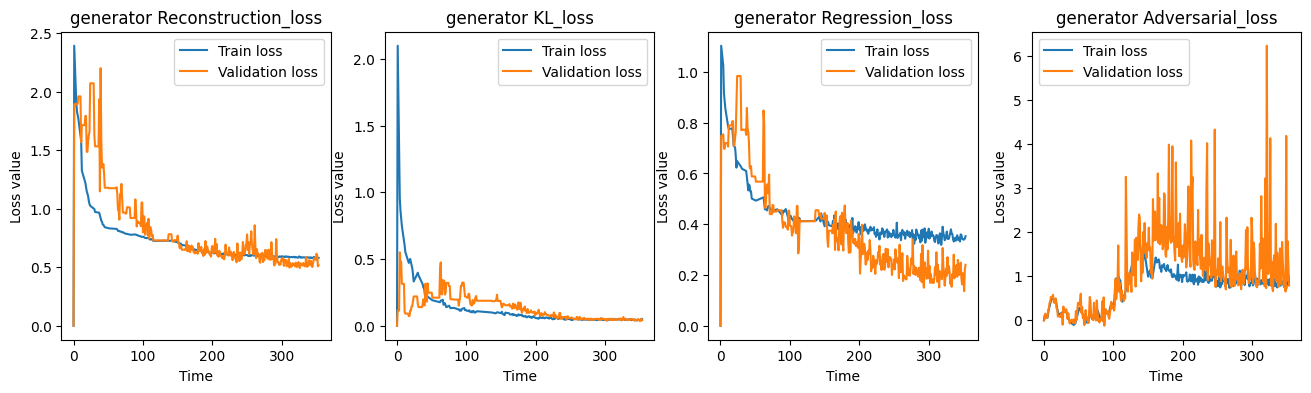

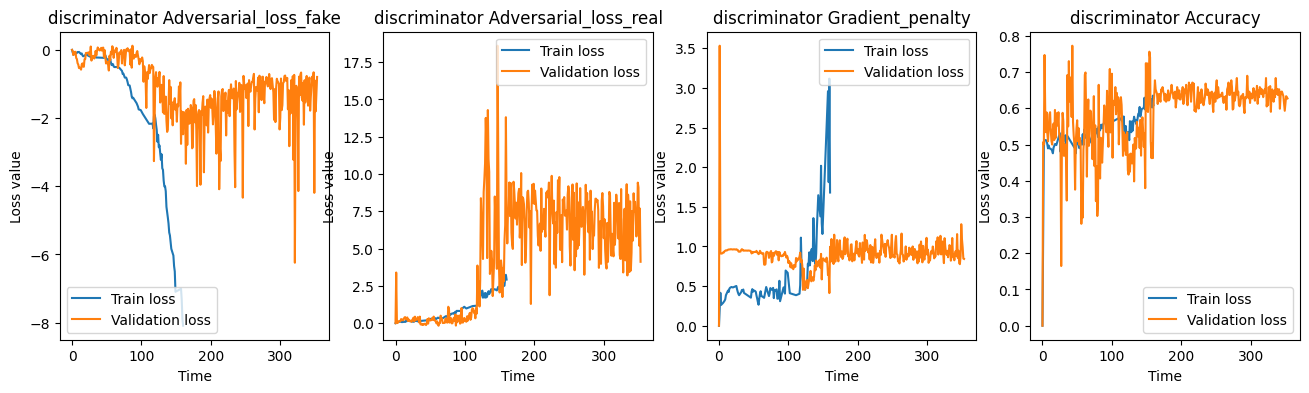

In [100]:
# PLOT THE TRAIN AND VALIDATION LOSSES THROUGH THE EPOCHS
net_VAE_GAN.plot_train_loss()

In [101]:
result = net_VAE_GAN.test(test_loader)

Epoch 353. Generator epoch 260 loss 6.144, Discriminator epoch 93 loss 50.783:
Generator: Reconstruction 0.812; KL 0.049; Regression 0.278; Adversarial 5.005
Discriminator: Adversarial fake -5.005 real 52.169; Gradient penalty 3.618; Accuracy 0.556


## Testing and visualisation

Epoch 353. Generator epoch 260 loss 6.121, Discriminator epoch 93 loss 30.631:
Generator: Reconstruction 0.812; KL 0.049; Regression 0.278; Adversarial 4.982
Discriminator: Adversarial fake -4.982 real 33.505; Gradient penalty 2.108; Accuracy 0.611
Number of images: 9


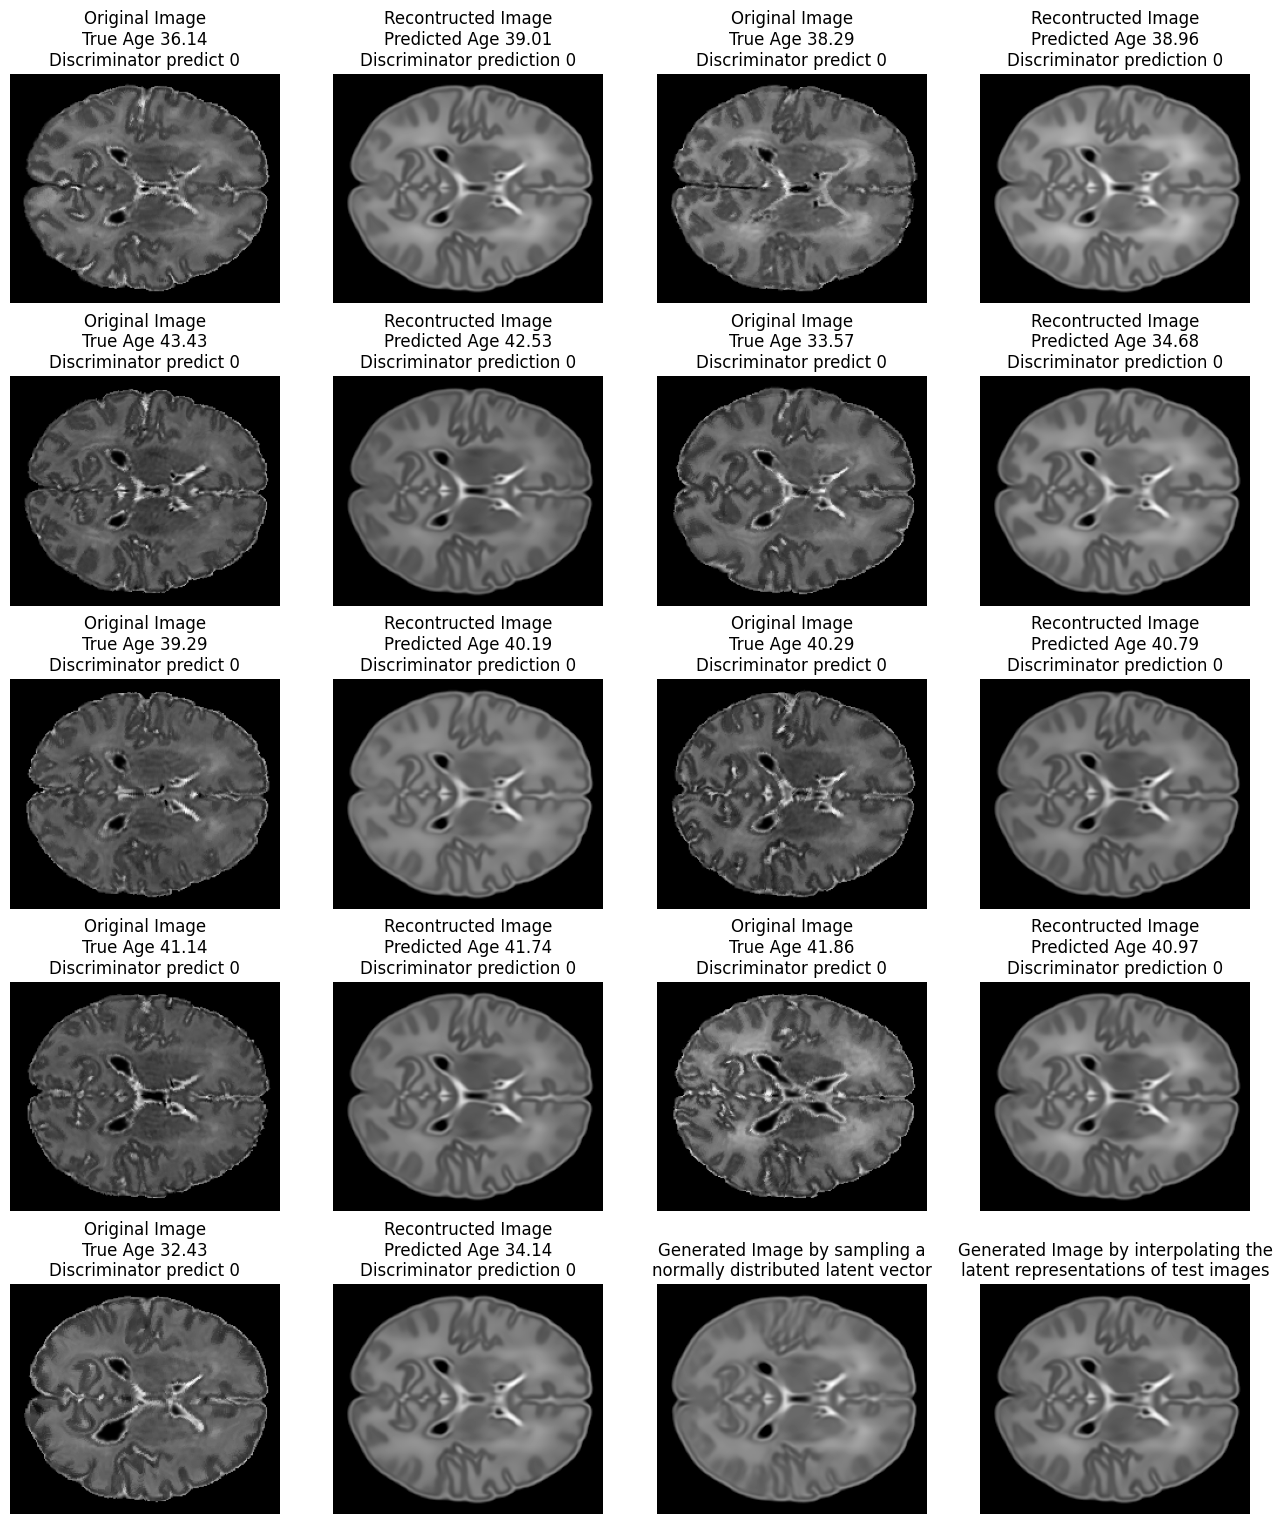

Age absolute error: Mean: 1.1271634101867676 - Std 0.7447443008422852
Reconstruction mse: Mean: 0.0017110465560108423 - Std 0.0062257698737084866


In [102]:
# TEST YOUR MODEL:
net_VAE_GAN.test(test_loader)

# DISPLAY THE INPUT AND RECONSTRUCTED IMAGES PLUS THE PREDICTED AGE VS. GROUND-TRUTH AGE FOR THE SUBJECTS IN YOUR TEST SET
# Get the sample and predict
input, output = next(iter(test_loader))
input=input.to(device)
# Reconstruct the image and predict the ages
generated_images = net_VAE_GAN.generator_model.reconstruct(input)
fake_predict = torch.sigmoid(net_VAE_GAN.discriminator_model(discriminator_augmentation_transform(generated_images))).detach().cpu()
fake_predict = fake_predict>=0.5
real_predict = torch.sigmoid(net_VAE_GAN.discriminator_model(discriminator_augmentation_transform(input))).detach().cpu()
real_predict = real_predict>=0.5
_, _, predict = net_VAE_GAN.generator_model(input)
predict = predict.cpu()
# predict = net_VAE_GAN.generator_model.classification_output.cpu()
print(f"Number of images: {len(input)}")
# Store two latent vectors to interpolate a new latent vector later
latent_vectors = net_VAE_GAN.generator_model.encoder_activation(net_VAE_GAN.generator_model.encoder(input))
latent_vectors = net_VAE_GAN.generator_model.mu(latent_vectors)
# Create the inverse normalization transformation
denormalize = Normalize(
    mean=[-m/s for m, s in zip([image_mean], [image_std])],
    std=[1/s for s in [image_std]])
# Get the image and inverse transform
input=denormalize(input.cpu())
generated_images=denormalize(generated_images.cpu().detach())
output = denormalize_age(output)
predict = denormalize_age(predict)
# Plot
rows = 5
columns = 4
fig = plt.figure(figsize = (16,19))
for i in range(len(output)):
    fig.add_subplot(rows, columns, 2*i+1)
    plt.title(f'Original Image\nTrue Age {round((output[i].item()),2)}\nDiscriminator predict {int(real_predict[i])}')
    plt.axis('off')
    plt.imshow(input[i].squeeze(), cmap = "gray")
    fig.add_subplot(rows, columns, 2*i+2)
    plt.title(f'Recontructed Image\nPredicted Age {round((predict[i].item()),2)}\nDiscriminator prediction {int(fake_predict[i])}')
    plt.axis('off')
    plt.imshow(generated_images[i].squeeze(), cmap = "gray")
i+=1

# Sample from latent space
z = torch.normal(0, 1, size = [1, *net_VAE_GAN.generator_model.encoder.output_size.to(torch.int32).tolist()]).to(device)
# Interpolate in the latent space
latent_vectors = latent_vectors.mean(dim=0).unsqueeze(0)
# Combine two latent vectors
z = torch.concat([z,latent_vectors], dim=0)
sample_image = net_VAE_GAN.generator_model.decoder(z)
sample_image = denormalize(sample_image.cpu().detach())
fig.add_subplot(rows, columns, 2*i+1)
plt.title(f'Generated Image by sampling a\nnormally distributed latent vector')
plt.axis('off')
plt.imshow(sample_image[0].squeeze(), cmap = "gray")
fig.add_subplot(rows, columns, 2*i+2)
plt.title(f'Generated Image by interpolating the\nlatent representations of test images')
plt.axis('off')
plt.imshow(sample_image[1].squeeze(), cmap = "gray")
plt.show()


# CALCULATE AVERAGE AND STANDARD DEVIATION OF THE MAE OF BRAIN AGE OF YOUR TEST SET
# CALCULATE AVERAGE AND STANDARD DEVIATION OF THE MSE of BRAIN RECONSTRUCTION OF YOUR TEST SET
age_mae = (output - predict).abs()
print(f"Age absolute error: Mean: {age_mae.mean()} - Std {age_mae.std()}")
reconstruction_mse = (generated_images - input)**2
print(f"Reconstruction mse: Mean: {reconstruction_mse.mean()} - Std {reconstruction_mse.std()}")

## Comment:
### Adding a discriminator significantly reduced the number of epochs I needed for training the VEA: achieved an MSE of 0.0017 after 307 epochs for the VAE-WGAN versus 0.0018 after 371 epochs for the VAE alone. However, the generated images' visual qualities didn't improve much.
### The GAN network is really hard to train, I really struggled with finding a ballance between the generator and discriminator.
### The discriminator easily overfitted the data. Adding those augmentations (random rotate, tranlate, shearing, flipping, and cropping). Significantly improve this condition.
### 700 images might be too few for training a GAN network (I believe the number of images for GAN can easily go up to thousands or millions).


# **Part 5 - Generating Samples**
In this section, I will generate samples from both VAE and VAE-WGAN.

In [103]:
# GENERATE NEW BRAIN IMAGES WITH YOUR TRAINED MODELs (VAE AND VAE-GAN) BY SAMPLING THE MEAN AND VARIANCE FROM THE LATENT SPACE
def generate_image_VAE(net, number_of_image=4):
    # Sample from latent space
    z = torch.normal(0, 1, size = [number_of_image, *net.model.encoder.output_size.to(torch.int32).tolist()]).to(device)
    sample_image = denormalize(net.model.decoder(z).cpu().detach())
    # Number of rows and columns for image
    columns=4
    rows=(number_of_image-1)//columns + 1
    fig = plt.figure(figsize = (columns*4,rows*4))
    def plot_image(image=None, rows=1, columns=4, index=1):
        if not image is None:
            fig.add_subplot(rows, columns, index)
            plt.title(f'Generated Image')
            plt.axis('off')
            plt.imshow(image.squeeze(), cmap = "gray")

    for i in range(number_of_image):
        plot_image(sample_image[i], rows, columns, i+1)
    plt.show()
    
# GENERATE NEW BRAIN IMAGES WITH YOUR TRAINED MODELs (VAE AND VAE-GAN) BY SAMPLING THE MEAN AND VARIANCE FROM THE LATENT SPACE
def generate_image_VAE_WGAN(net, number_of_image=4):
    # Sample from latent space
    z = torch.normal(0, 1, size = [number_of_image, *net.generator_model.encoder.output_size.to(torch.int32).tolist()]).to(device)
    sample_image = denormalize(net.generator_model.decoder(z).cpu().detach())
    # Number of rows and columns for image
    columns=4
    rows=(number_of_image-1)//columns + 1
    fig = plt.figure(figsize = (columns*4,rows*4))
    def plot_image(image=None, rows=1, columns=4, index=1):
        if not image is None:
            fig.add_subplot(rows, columns, index)
            plt.title(f'Generated Image')
            plt.axis('off')
            plt.imshow(image.squeeze(), cmap = "gray")

    for i in range(number_of_image):
        plot_image(sample_image[i], rows, columns, i+1)
    plt.show()

## Generate image with VAE

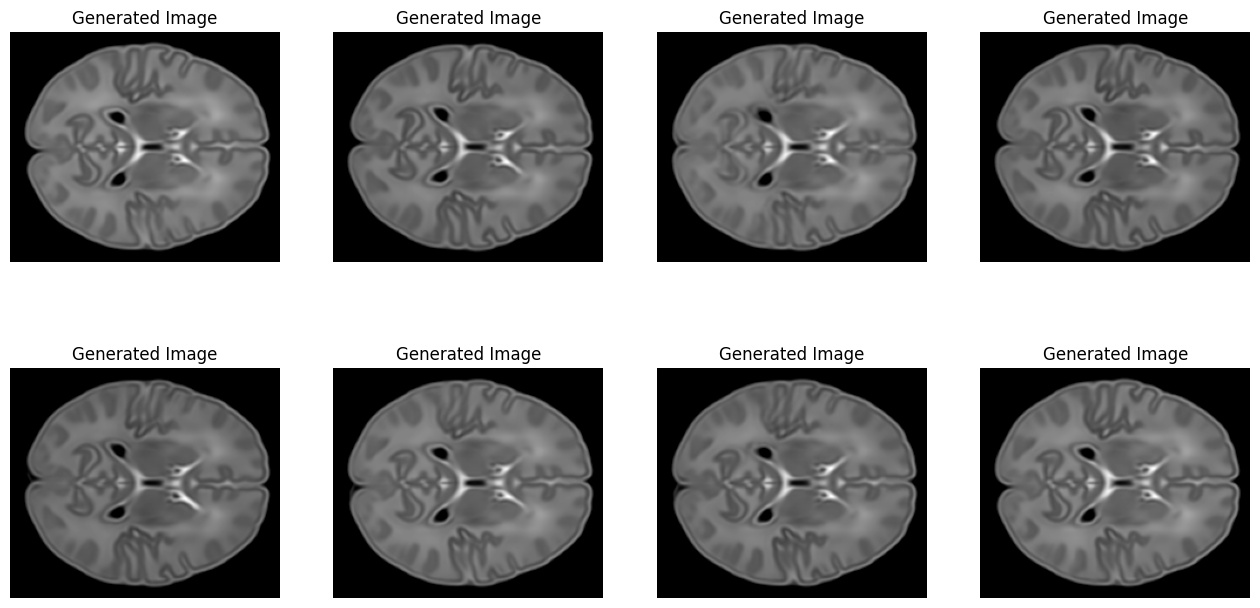

In [104]:
# DISPLAY GENERATED IMAGES
generate_image_VAE(net_VAE, 8)

## Generate image with VAE-WGAN

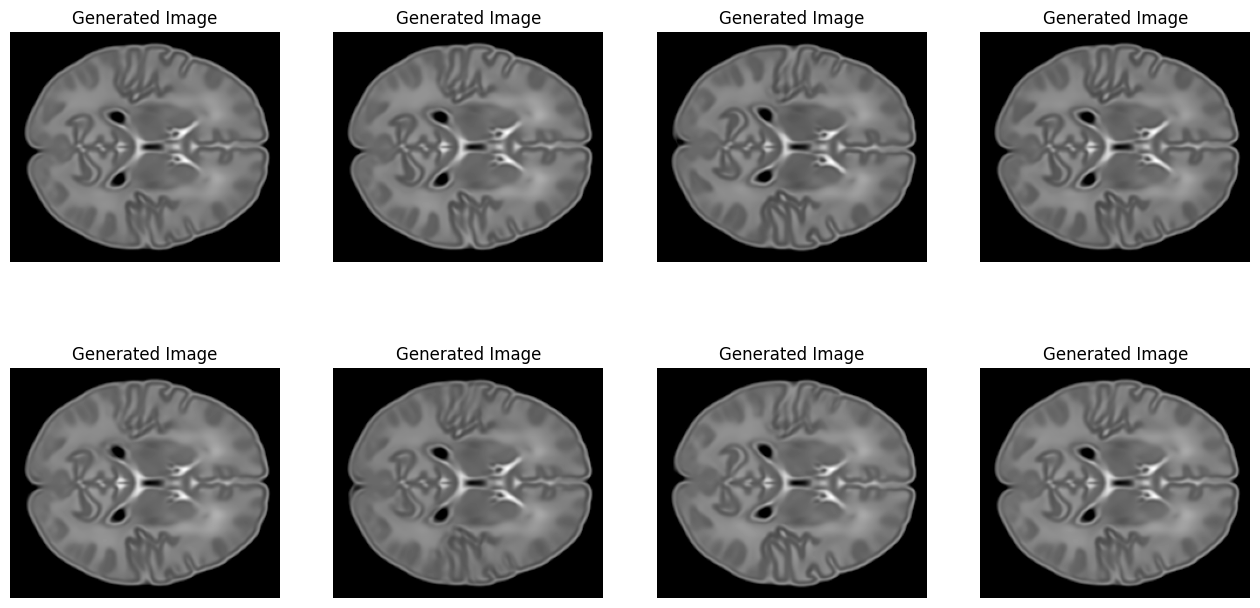

In [105]:
# DISPLAY GENERATED IMAGES
generate_image_VAE_WGAN(net_VAE_GAN, 8)